# Projeto Final
## Curso de Engenheiro de Machine Learning - Udacity



## Classificação Litológica Automatizada a Partir de Dados de Química de Rocha


### Importanto Bibliotecas e Configurando Matplotlib

In [1534]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import display
import time
%matplotlib inline

plt.style.available
#plt.style.use('ggplot')

plt.style.use('fivethirtyeight')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format

rc={'savefig.dpi': 350, 'figure.autolayout': False, 'figure.figsize': [15, 5], 'axes.labelsize': 10,\
   'axes.titlesize': 18, 'font.size': 8, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 12,\
   'xtick.labelsize': 12, 'ytick.labelsize': 12}

sns.set(style='dark',rc=rc)
np.set_printoptions(linewidth=120) 

In [1535]:
default_color = '#56B4E9'
colormap = plt.cm.cool

In [1536]:
# Setting working directory
path = 'dados/raw/'

### Carregando Dados

In [1537]:
files = np.array(glob(path + "*"))
#read them into pandas
df_list = [pd.read_csv(file, na_values=-1) for file in files]
#concatenate them together
df = pd.concat(df_list,ignore_index=True)


In [1538]:
df.shape

(22232, 172)

In [1539]:
df.describe()

LATITUDE MIN  LATITUDE MAX  LONGITUDE MIN  LONGITUDE MAX  \
count      21481.00      21481.00       21481.00       21481.00   
mean          25.15         25.17           9.96           9.97   
std           38.28         38.38          76.57          76.70   
min          -34.95        -34.95        -185.93        -186.00   
25%          -21.81        -22.00         -77.63         -77.63   
50%           48.20         48.20          29.09          29.10   
75%           62.67         62.71          76.50          76.50   
max           74.69         74.69         136.27         136.27   

       ELEVATION MIN  ELEVATION MAX  ERUPTION DAY  ERUPTION MONTH  \
count          41.00          41.00          0.00            0.00   
mean          633.88         633.88           nan             nan   
std           492.03         492.03           nan             nan   
min           234.70         234.70           nan             nan   
25%           234.70         234.70           nan             nan   
50%           492.00         492.00           nan             nan   
75%           886.00         886.00           nan             nan   
max          1928.00        1928.00           nan             nan   

       ERUPTION YEAR  DRILL DEPTH MIN      ...       RE187_OS186  RE187_OS188  \
count           0.00          1253.00      ...             36.00       224.00   
mean             nan           322.12      ...            722.96        28.55   
std              nan           499.86      ...           2371.75       202.07   
min              nan             0.30      ...              1.48         0.01   
25%              nan            95.70      ...             20.23         0.23   
50%              nan           205.00      ...             27.23         0.69   
75%              nan           357.00      ...             79.00         1.72   
max              nan          4780.00      ...          13900.00      2303.00   

       HF176_HF177  HE3_HE4  HE3_HE4(R/R(A))  HE4_HE3  HE4_HE3(R/R(A))  \
count       355.00     0.00            14.00     0.00             0.00   
mean          0.28      nan            14.60      nan              nan   
std           0.00      nan            14.31      nan              nan   
min           0.28      nan             0.05      nan              nan   
25%           0.28      nan             0.91      nan              nan   
50%           0.28      nan            10.50      nan              nan   
75%           0.28      nan            25.35      nan              nan   
max           0.30      nan            39.10      nan              nan   

       K40_AR40  AR40_K40  Unnamed: 171  
count      0.00      0.00          0.00  
mean        nan       nan           nan  
std         nan       nan           nan  
min         nan       nan           nan  
25%         nan       nan           nan  
50%         nan       nan           nan  
75%         nan       nan           nan  
max         nan       nan           nan  

[8 rows x 155 columns]

In [1540]:
df.columns[:30]

Index([u'CITATIONS', u'TECTONIC SETTING', u'LOCATION', u'LOCATION COMMENT',
       u'LATITUDE MIN', u'LATITUDE MAX', u'LONGITUDE MIN', u'LONGITUDE MAX',
       u'LAND OR SEA', u'ELEVATION MIN', u'ELEVATION MAX', u'SAMPLE NAME',
       u'ROCK NAME', u'MIN. AGE (YRS.)', u'MAX. AGE (YRS.)', u'GEOL.', u'AGE',
       u'ERUPTION DAY', u'ERUPTION MONTH', u'ERUPTION YEAR', u'ROCK TEXTURE',
       u'ROCK TYPE', u'DRILL DEPTH MIN', u'DRILL DEPTHAX', u'ALTERATION',
       u'MINERAL', u'MATERIAL', u'SIO2(WT%)', u'TIO2(WT%)', u'B2O3(WT%)'],
      dtype='object')

### Analisando os valores da coluna alvo

#### Visualisar tipos de rochas presentes nos dados

In [1541]:
df['ROCK TYPE'].value_counts()

VOL     14584
PLU      3349
MET      2409
SED       547
VEIN      192
ORE       164
PER       104
ORE        63
PEG        20
Name: ROCK TYPE, dtype: int64

TIPO DE ROCHA: 
- VOL = Vulcânica 
- PLU = Plutônica
- MET = Metamórfica
- SED = Sedimentar
- VEIN = Veio
- ORE = Minério
- PER = Peridotito
- PEG = Pegmatito

#### Manter apenas linhas com análises de rochas Vulcânicas
- As rochas plutonica apresentam química semelhante aos seus pares vulcânicos, pois possuem mesma composição, modificando apenas o processo de formação. Plutonicas são formadas pela cristalização magmática em profundidade (interior da Terra) e vulcanicas são formadas pela cristalização magmática subáerea ou subáquosa. Portanto, essas rochas podem confundir o modelo.

- As rochas Metamórficas, também podem possuir química semelhante as demias rochas, pois são produto da deformação de uma determinada rocha. Ex. Se uma rocha sedimentar é deformada ela se torna uma rocha metamórfia porem sua quimica continua semelhante, ou muito parecida com a quimica de seu protolito sedimentar. Portanto estas rochas também podem confundir o modelo.

- As rochas sedimentares são formadas pela eroção das rochas, portanto, pode carregar caracteristicas quimicas de todos os tipos de rocha, podendo assim confundir o modelo

- Os demais tipos de rocha não foram considerados pela sua ocorrência restrita na natureza e também pelo pequeno numero de amostras destes tipos no banco de dados.

In [1542]:
df = df[df['ROCK TYPE'].isin(['VOL'])]

#### Remover amostras alteradas, manter apenas as que 'ALTERATION' = nan

In [1543]:
df = df[pd.isnull(df['ALTERATION'])]

In [1544]:
target_names = df['ROCK NAME'].unique()
print 'Total de valores alvo unicos:  %d' % len(target_names)

Total de valores alvo unicos:  1469


In [1545]:
target_names.sort(axis=0)

In [1546]:
target_names[:1000]

array(['ABSAROKITE [5844]', 'ADAKITE [10270]', 'ADAKITE [10558]', 'ADAKITE [12271]', 'ADAKITE [12642]',
       'ADAKITE [13224]', 'ADAKITE [13427]', 'ADAKITE [13546]', 'ADAKITE [13550]', 'ADAKITE [18193]', 'ADAKITE [19258]',
       'ADAKITE [5575]', 'ADAKITE [5582]', 'ADAKITE [6954]', 'ADAKITE [7189]', 'ADAKITE [9441]', 'ANDESITE [10349]',
       'ANDESITE [10897]', 'ANDESITE [11014]', 'ANDESITE [11105]', 'ANDESITE [11250]', 'ANDESITE [11947]',
       'ANDESITE [12271]', 'ANDESITE [12582]', 'ANDESITE [12863]', 'ANDESITE [12870]', 'ANDESITE [12939]',
       'ANDESITE [13224]', 'ANDESITE [13427]', 'ANDESITE [13546]', 'ANDESITE [13590]',
       'ANDESITE [13673] / NOT GIVEN [13590]', 'ANDESITE [13676]', 'ANDESITE [13777]', 'ANDESITE [13799]',
       'ANDESITE [13997]', 'ANDESITE [14093]', 'ANDESITE [14511]', 'ANDESITE [14982]', 'ANDESITE [16345]',
       'ANDESITE [16378]', 'ANDESITE [16588]', 'ANDESITE [1688]', 'ANDESITE [17170]', 'ANDESITE [17419]',
       'ANDESITE [17722]', 'ANDESITE 

### Removendo valores numéricos ( "[nnnnn]" ) presentes nos valores da variavel alvo

In [1547]:
def remove_numbers_from_target(string):
    
    end = string.find( ' [' )
    result = string
    if end != -1:
      result = string[:end]
    return result

In [1548]:
df['ROCK NAME']

0         KOMATIITE [7150]
1         KOMATIITE [7150]
2         KOMATIITE [7150]
3         KOMATIITE [7150]
4         KOMATIITE [7150]
5         KOMATIITE [7150]
6         KOMATIITE [7150]
7         KOMATIITE [7150]
8         KOMATIITE [7150]
9         KOMATIITE [7150]
10        KOMATIITE [7150]
11        KOMATIITE [7150]
12           BASALT [7150]
13        KOMATIITE [7150]
14        KOMATIITE [7150]
15        KOMATIITE [7150]
16        KOMATIITE [7150]
17        KOMATIITE [7150]
18           BASALT [7150]
19           BASALT [7150]
20           BASALT [7150]
21           BASALT [7150]
22           BASALT [7150]
23           BASALT [7150]
24           BASALT [7150]
25           BASALT [7150]
26           BASALT [7150]
27           BASALT [6004]
28           BASALT [6004]
29          PICRITE [6004]
               ...        
22176    KOMATIITE [13648]
22177    KOMATIITE [13648]
22178    KOMATIITE [13648]
22179    KOMATIITE [13648]
22180    KOMATIITE [13648]
22181    KOMATIITE [13648]
2

In [1549]:
df['ROCK NAME'] = df['ROCK NAME'].apply(str).apply(remove_numbers_from_target)

In [1550]:
df['ROCK NAME']

0        KOMATIITE
1        KOMATIITE
2        KOMATIITE
3        KOMATIITE
4        KOMATIITE
5        KOMATIITE
6        KOMATIITE
7        KOMATIITE
8        KOMATIITE
9        KOMATIITE
10       KOMATIITE
11       KOMATIITE
12          BASALT
13       KOMATIITE
14       KOMATIITE
15       KOMATIITE
16       KOMATIITE
17       KOMATIITE
18          BASALT
19          BASALT
20          BASALT
21          BASALT
22          BASALT
23          BASALT
24          BASALT
25          BASALT
26          BASALT
27          BASALT
28          BASALT
29         PICRITE
           ...    
22176    KOMATIITE
22177    KOMATIITE
22178    KOMATIITE
22179    KOMATIITE
22180    KOMATIITE
22181    KOMATIITE
22182    KOMATIITE
22183    KOMATIITE
22184    KOMATIITE
22185    KOMATIITE
22186    KOMATIITE
22187    KOMATIITE
22188    KOMATIITE
22189    KOMATIITE
22190    KOMATIITE
22191    KOMATIITE
22192    KOMATIITE
22193    KOMATIITE
22194    KOMATIITE
22195    KOMATIITE
22196    KOMATIITE
22197    KOM

In [1551]:
target_names = df['ROCK NAME'].unique()
print 'Total de valores alvo unicos:  %d' % len(target_names)

Total de valores alvo unicos:  76


#### Observação:
Total de valores alvo diminuiram pois o valor numérico ( "[nnnnn]" ) duplicava valores unicos

#### Remover espaços em branco no começo e no final dos valores da varivel alvo (evitar valores identicos duplicados)

In [1552]:
df['ROCK NAME'] = df['ROCK NAME'].str.strip()

#### Plotar valores unicos novos da variavel alvo

In [1553]:
target_names.sort()

In [1554]:
print '\n'.join([ e for e in target_names ])

ABSAROKITE
ADAKITE
ANDESITE
ANDESITE, BASALTIC
ANDESITE, BASALTIC, CALC-ALKALINE
ANDESITE, BASALTIC, THOLEIITIC
ANDESITE, CALC-ALKALINE
ANDESITE, HORNBLENDE
ANDESITE, KOMATIITIC
ANDESITE, THOLEIITIC
BASALT
BASALT 
BASALT CUMULATE
BASALT, ALKALINE
BASALT, ALKALINE, OLIVINE
BASALT, ANDESITIC
BASALT, CALC-ALKALINE
BASALT, KOMATIITIC
BASALT, OLIVINE
BASALT, PICRITIC
BASALT, PLAGIOCLASE
BASALT, PLAGIOCLASE-CLINOPYROXENE
BASALT, PLAGIOCLASE-PYROXENE
BASALT, PYROXENE
BASALT, SUBALKALINE
BASALT, THOLEIITIC
BASALT, TRANSITIONAL
BONINITE
BONINITE CUMULATE
DACITE
DACITE, CALC-ALKALINE
DACITE, FELDSPAR
DACITE, THOLEIITIC
DOLERITE
DOLERITE, KOMATIITIC
HAWAIITE
KOMATIITE
KOMATIITE 
KOMATIITE, BASALTIC
KOMATIITE, PERIDOTITIC
KOMATIITE, PERIDOTITIC, OLIVINE
KOMATIITE, PYROXENITIC
LEUCITITE
MUGEARITE
NEPHELINITE
NOT GIVEN
PANTELLERITE
PHONOLITE, LEUCITE
PHONOTEPHRITE
PICRITE
PICRITE, FERRO
PICRITE, KOMATIITIC
PICRITE, THOLEIITIC
PORPHYRITE
PORPHYRITE, PLAGIOCLASE
RHYODACITE
RHYOLITE
RHYOLITE, CALC-ALKA

### Análise de contagem de valores unicos na variável alvo

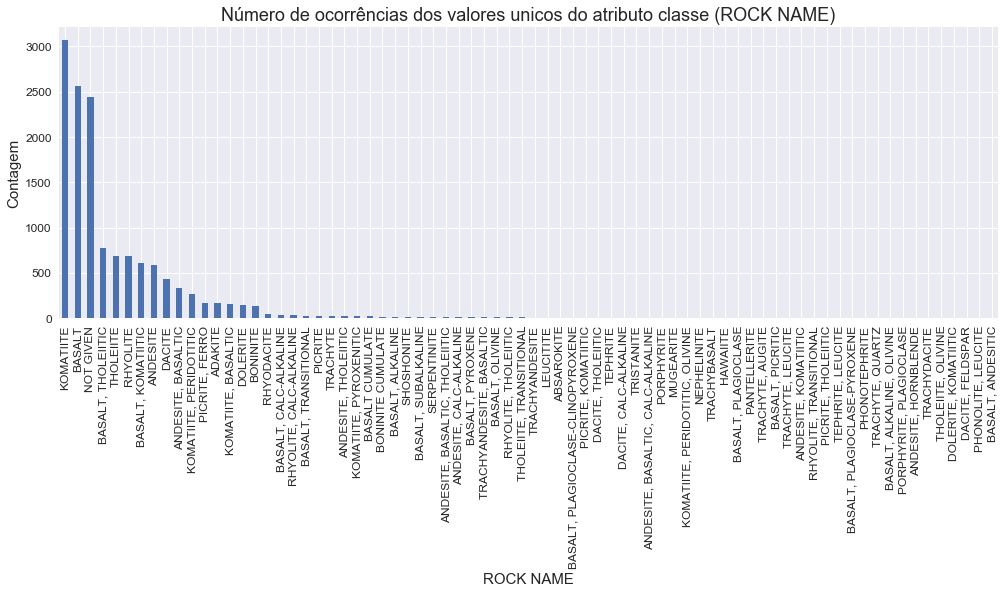

In [1555]:
target = df['ROCK NAME']

plt.figure(figsize=(15,5))

ax = df['ROCK NAME'].value_counts().plot(kind = 'bar', title= u'Número de ocorrências dos valores unicos do atributo classe (ROCK NAME)')

ax.grid(True)
#ax = sns.countplot('ROCK NAME',data=df,color=default_color, order = target.value_counts().index)
#ax.set(xticklabels=[])
ax.set_xlabel('ROCK NAME',fontsize= 15)
ax.set_ylabel('Contagem',fontsize= 15)
plt.savefig('imgs/Fig_1.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')
plt.show()


In [1556]:
target.value_counts()

KOMATIITE                            3065
BASALT                               2563
NOT GIVEN                            2439
BASALT, THOLEIITIC                    776
THOLEIITE                             687
RHYOLITE                              686
BASALT, KOMATIITIC                    613
ANDESITE                              583
DACITE                                433
ANDESITE, BASALTIC                    333
KOMATIITE, PERIDOTITIC                270
PICRITE, FERRO                        167
ADAKITE                               167
KOMATIITE, BASALTIC                   155
DOLERITE                              150
BONINITE                              136
RHYODACITE                             47
BASALT, CALC-ALKALINE                  38
RHYOLITE, CALC-ALKALINE                38
BASALT, TRANSITIONAL                   28
PICRITE                                25
TRACHYTE                               24
ANDESITE, THOLEIITIC                   22
KOMATIITE, PYROXENITIC            

### Removendo valores da variavel alvo com contagem < 10

In [1557]:
target_lt_1 = [x for x in target.value_counts().index if target.value_counts()[x] >= 10]

In [1558]:
with pd.option_context('display.max_rows', 200):
    print (target.value_counts()[target_lt_1])
    print len(target.value_counts()[target_lt_1])

KOMATIITE                         3065
BASALT                            2563
NOT GIVEN                         2439
BASALT, THOLEIITIC                 776
THOLEIITE                          687
RHYOLITE                           686
BASALT, KOMATIITIC                 613
ANDESITE                           583
DACITE                             433
ANDESITE, BASALTIC                 333
KOMATIITE, PERIDOTITIC             270
PICRITE, FERRO                     167
ADAKITE                            167
KOMATIITE, BASALTIC                155
DOLERITE                           150
BONINITE                           136
RHYODACITE                          47
BASALT, CALC-ALKALINE               38
RHYOLITE, CALC-ALKALINE             38
BASALT, TRANSITIONAL                28
PICRITE                             25
TRACHYTE                            24
ANDESITE, THOLEIITIC                22
KOMATIITE, PYROXENITIC              21
BASALT CUMULATE                     21
BONINITE CUMULATE        

### Removendo valores vazios ( 'NOT GIVEN' e 'nan') da variavel alvo

In [1559]:
try:
    target_lt_1.remove('NOT GIVEN')
    target_lt_1.remove('nan')
except:
    pass

### Executanto a remoção

In [1560]:
df = df[df['ROCK NAME'].isin(target_lt_1)]
df.shape

(11143, 172)

### Plotanto numero de ocorrencias da variavel alvo

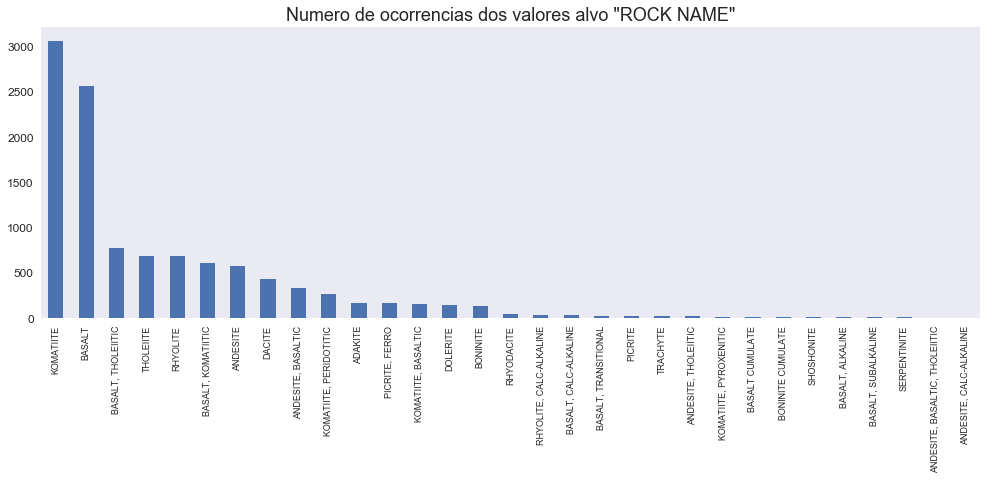

In [1561]:
target = df['ROCK NAME']

plt.figure(figsize=(15,5))
plt.xticks(fontsize=9)

ax = df['ROCK NAME'].value_counts().plot(kind = 'bar', title= 'Numero de ocorrencias dos valores alvo "ROCK NAME"')
#ax = sns.countplot('ROCK NAME',data=df,color=default_color, order = target.value_counts().index)
#ax.set(xticklabels=[])

plt.show()

In [1562]:
with pd.option_context('display.max_rows', 200):
    print (target.value_counts()[target_lt_1])
    print len(target.value_counts()[target_lt_1])

KOMATIITE                         3065
BASALT                            2563
BASALT, THOLEIITIC                 776
THOLEIITE                          687
RHYOLITE                           686
BASALT, KOMATIITIC                 613
ANDESITE                           583
DACITE                             433
ANDESITE, BASALTIC                 333
KOMATIITE, PERIDOTITIC             270
PICRITE, FERRO                     167
ADAKITE                            167
KOMATIITE, BASALTIC                155
DOLERITE                           150
BONINITE                           136
RHYODACITE                          47
BASALT, CALC-ALKALINE               38
RHYOLITE, CALC-ALKALINE             38
BASALT, TRANSITIONAL                28
PICRITE                             25
TRACHYTE                            24
ANDESITE, THOLEIITIC                22
KOMATIITE, PYROXENITIC              21
BASALT CUMULATE                     21
BONINITE CUMULATE                   17
BASALT, ALKALINE         

### Análise dos dados

#### Criar Matriz de Metadados

In [1563]:
def get_meta(train, not_keep_list = []):
    data = []
    for col in df.columns:
        # Defining the role
        if col == 'ROCK NAME':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'
        else:
            level = 'string'
            

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False
        elif col in not_keep_list:
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

In [1564]:
meta_data = get_meta(df)
with pd.option_context('display.max_rows', 200):
    display(meta_data)

role     level  keep    dtype
varname                                          
CITATIONS          input    string  True   object
TECTONIC SETTING   input    string  True   object
LOCATION           input    string  True   object
LOCATION COMMENT   input    string  True   object
LATITUDE MIN       input  interval  True  float64
LATITUDE MAX       input  interval  True  float64
LONGITUDE MIN      input  interval  True  float64
LONGITUDE MAX      input  interval  True  float64
LAND OR SEA        input    string  True   object
ELEVATION MIN      input  interval  True  float64
ELEVATION MAX      input  interval  True  float64
SAMPLE NAME        input    string  True   object
ROCK NAME         target    string  True   object
MIN. AGE (YRS.)    input    string  True   object
MAX. AGE (YRS.)    input    string  True   object
GEOL.              input    string  True   object
AGE                input    string  True   object
ERUPTION DAY       input  interval  True  float64
ERUPTION MONTH     input  interval  True  float64
ERUPTION YEAR      input  interval  True  float64
ROCK TEXTURE       input    string  True   object
ROCK TYPE          input    string  True   object
DRILL DEPTH MIN    input  interval  True  float64
DRILL DEPTHAX      input  interval  True  float64
ALTERATION         input    string  True   object
MINERAL            input    string  True   object
MATERIAL           input    string  True   object
SIO2(WT%)          input  interval  True  float64
TIO2(WT%)          input  interval  True  float64
B2O3(WT%)          input  interval  True  float64
AL2O3(WT%)         input  interval  True  float64
CR2O3(WT%)         input  interval  True  float64
FE2O3(WT%)         input  interval  True  float64
FEO(WT%)           input  interval  True  float64
FEOT(WT%)          input  interval  True  float64
CAO(WT%)           input  interval  True  float64
MGO(WT%)           input  interval  True  float64
MNO(WT%)           input  interval  True  float64
NIO(WT%)           input  interval  True  float64
K2O(WT%)           input  interval  True  float64
NA2O(WT%)          input  interval  True  float64
P2O5(WT%)          input  interval  True  float64
H2O(WT%)           input  interval  True  float64
H2OP(WT%)          input  interval  True  float64
H2OM(WT%)          input  interval  True  float64
H2OT(WT%)          input  interval  True  float64
CO2(WT%)           input  interval  True  float64
CO1(WT%)           input  interval  True  float64
F(WT%)             input  interval  True  float64
CL(WT%)            input  interval  True  float64
CL2(WT%)           input  interval  True  float64
OH(WT%)            input  interval  True  float64
CH4(WT%)           input  interval  True  float64
SO2(WT%)           input  interval  True  float64
SO3(WT%)           input  interval  True  float64
SO4(WT%)           input  interval  True  float64
S(WT%)             input  interval  True  float64
LOI(WT%)           input  interval  True  float64
VOLATILES(WT%)     input  interval  True  float64
O(WT%)             input  interval  True  float64
OTHERS(WT%)        input  interval  True  float64
HE(CCM/G)          input  interval  True  float64
HE(CCMSTP/G)       input  interval  True  float64
HE3(CCMSTP/G)      input  interval  True  float64
HE3(AT/G)          input  interval  True  float64
HE4(CCM/G)         input  interval  True  float64
HE4(CCMSTP/G)      input  interval  True  float64
HE4(AT/G)          input  interval  True  float64
HE4(MOLE/G)        input  interval  True  float64
HE4(NCC/G)         input  interval  True  float64
HE(NCC/G)          input  interval  True  float64
LI(PPM)            input  interval  True  float64
BE(PPM)            input  interval  True  float64
B(PPM)             input  interval  True  float64
C(PPM)             input  interval  True  float64
CO2(PPM)           input  interval  True  float64
F(PPM)             input  interval  True  float64
NA(PPM)            input  interval  True  float64
MG(PPM)            i

### Mater apenas as colunas com análises químicas e a variavél alvo, remover demais colunas

#### Criar lista das colunas antes da primeira análise química

In [1565]:
first_quim_analises_index = np.where(df.columns == 'SIO2(WT%)')[0][0]

In [1566]:
remove_columns_top = df.columns[:first_quim_analises_index].values
index = np.where(remove_columns_top == 'ROCK NAME')[0][0] #Remover a coluna da variavel alvo da lista
remove_columns_top = np.delete(remove_columns_top, index)
remove_columns_top

array(['CITATIONS', 'TECTONIC SETTING', 'LOCATION', 'LOCATION COMMENT', 'LATITUDE MIN', 'LATITUDE MAX', 'LONGITUDE MIN',
       'LONGITUDE MAX', 'LAND OR SEA', 'ELEVATION MIN', 'ELEVATION MAX', 'SAMPLE NAME', 'MIN. AGE (YRS.)',
       'MAX. AGE (YRS.)', 'GEOL.', 'AGE', 'ERUPTION DAY', 'ERUPTION MONTH', 'ERUPTION YEAR', 'ROCK TEXTURE',
       'ROCK TYPE', 'DRILL DEPTH MIN', 'DRILL DEPTHAX', 'ALTERATION', 'MINERAL', 'MATERIAL'], dtype=object)

#### Criar lista das colunas depois da ultima análise química

In [1567]:
last_quim_analises_index = np.where(df.columns == 'U(PPM)')[0][0]

In [1568]:
remove_columns_bottom = df.columns[last_quim_analises_index + 1:].values
remove_columns_bottom

array(['ND143_ND144', 'ND143_ND144_INI', 'EPSILON_ND', 'SR87_SR86', 'SR87_SR86_INI', 'PB206_PB204', 'PB206_PB204_INI',
       'PB207_PB204', 'PB207_PB204_INI', 'PB208_PB204', 'PB208_PB204_INI', 'OS184_OS188', 'OS186_OS188', 'OS187_OS186',
       'OS187_OS188', 'RE187_OS186', 'RE187_OS188', 'HF176_HF177', 'HE3_HE4', 'HE3_HE4(R/R(A))', 'HE4_HE3',
       'HE4_HE3(R/R(A))', 'K40_AR40', 'AR40_K40', 'UNIQUE_ID', 'Unnamed: 171'], dtype=object)

#### Agrupar as duas listas

In [1569]:
remove_columns = np.concatenate((remove_columns_top,remove_columns_bottom),axis=0)
remove_columns

array(['CITATIONS', 'TECTONIC SETTING', 'LOCATION', 'LOCATION COMMENT', 'LATITUDE MIN', 'LATITUDE MAX', 'LONGITUDE MIN',
       'LONGITUDE MAX', 'LAND OR SEA', 'ELEVATION MIN', 'ELEVATION MAX', 'SAMPLE NAME', 'MIN. AGE (YRS.)',
       'MAX. AGE (YRS.)', 'GEOL.', 'AGE', 'ERUPTION DAY', 'ERUPTION MONTH', 'ERUPTION YEAR', 'ROCK TEXTURE',
       'ROCK TYPE', 'DRILL DEPTH MIN', 'DRILL DEPTHAX', 'ALTERATION', 'MINERAL', 'MATERIAL', 'ND143_ND144',
       'ND143_ND144_INI', 'EPSILON_ND', 'SR87_SR86', 'SR87_SR86_INI', 'PB206_PB204', 'PB206_PB204_INI', 'PB207_PB204',
       'PB207_PB204_INI', 'PB208_PB204', 'PB208_PB204_INI', 'OS184_OS188', 'OS186_OS188', 'OS187_OS186', 'OS187_OS188',
       'RE187_OS186', 'RE187_OS188', 'HF176_HF177', 'HE3_HE4', 'HE3_HE4(R/R(A))', 'HE4_HE3', 'HE4_HE3(R/R(A))',
       'K40_AR40', 'AR40_K40', 'UNIQUE_ID', 'Unnamed: 171'], dtype=object)

#### Recalcular meta_data com nova lista de colunas a serem excluidas

In [1570]:
meta_data = get_meta(df,remove_columns)
with pd.option_context('display.max_rows', 200):
    display(meta_data)

role     level   keep    dtype
varname                                           
CITATIONS          input    string  False   object
TECTONIC SETTING   input    string  False   object
LOCATION           input    string  False   object
LOCATION COMMENT   input    string  False   object
LATITUDE MIN       input  interval  False  float64
LATITUDE MAX       input  interval  False  float64
LONGITUDE MIN      input  interval  False  float64
LONGITUDE MAX      input  interval  False  float64
LAND OR SEA        input    string  False   object
ELEVATION MIN      input  interval  False  float64
ELEVATION MAX      input  interval  False  float64
SAMPLE NAME        input    string  False   object
ROCK NAME         target    string   True   object
MIN. AGE (YRS.)    input    string  False   object
MAX. AGE (YRS.)    input    string  False   object
GEOL.              input    string  False   object
AGE                input    string  False   object
ERUPTION DAY       input  interval  False  float64
ERUPTION MONTH     input  interval  False  float64
ERUPTION YEAR      input  interval  False  float64
ROCK TEXTURE       input    string  False   object
ROCK TYPE          input    string  False   object
DRILL DEPTH MIN    input  interval  False  float64
DRILL DEPTHAX      input  interval  False  float64
ALTERATION         input    string  False   object
MINERAL            input    string  False   object
MATERIAL           input    string  False   object
SIO2(WT%)          input  interval   True  float64
TIO2(WT%)          input  interval   True  float64
B2O3(WT%)          input  interval   True  float64
AL2O3(WT%)         input  interval   True  float64
CR2O3(WT%)         input  interval   True  float64
FE2O3(WT%)         input  interval   True  float64
FEO(WT%)           input  interval   True  float64
FEOT(WT%)          input  interval   True  float64
CAO(WT%)           input  interval   True  float64
MGO(WT%)           input  interval   True  float64
MNO(WT%)           input  interval   True  float64
NIO(WT%)           input  interval   True  float64
K2O(WT%)           input  interval   True  float64
NA2O(WT%)          input  interval   True  float64
P2O5(WT%)          input  interval   True  float64
H2O(WT%)           input  interval   True  float64
H2OP(WT%)          input  interval   True  float64
H2OM(WT%)          input  interval   True  float64
H2OT(WT%)          input  interval   True  float64
CO2(WT%)           input  interval   True  float64
CO1(WT%)           input  interval   True  float64
F(WT%)             input  interval   True  float64
CL(WT%)            input  interval   True  float64
CL2(WT%)           input  interval   True  float64
OH(WT%)            input  interval   True  float64
CH4(WT%)           input  interval   True  float64
SO2(WT%)           input  interval   True  float64
SO3(WT%)           input  interval   True  float64
SO4(WT%)           input  interval   True  float64
S(WT%)             input  interval   True  float64
LOI(WT%)           input  interval   True  float64
VOLATILES(WT%)     input  interval   True  float64
O(WT%)             input  interval   True  float64
OTHERS(WT%)        input  interval   True  float64
HE(CCM/G)          input  interval   True  float64
HE(CCMSTP/G)       input  interval   True  float64
HE3(CCMSTP/G)      input  interval   True  float64
HE3(AT/G)          input  interval   True  float64
HE4(CCM/G)         input  interval   True  float64
HE4(CCMSTP/G)      input  interval   True  float64
HE4(AT/G)          input  interval   True  float64
HE4(MOLE/G)        input  interval   True  float64
HE4(NCC/G)         input  interval   True  float64
HE(NCC/G)          input  interval   True  float64
LI(PPM)            input  interval   True  float64
BE(PPM)            input  interval   True  float64
B(PPM)             input  interval   True  float64
C(PPM)             input  interval   True  float64
CO2(PPM)           input  interval   True  float64
F(PPM)             input  interval   True 

In [1571]:
meta_counts = meta_data[meta_data['keep'] == True].groupby(['role', 'level']).agg({'dtype': lambda x: x.count() }).reset_index()
meta_counts

role     level  dtype
0   input  interval    119
1  target    string      1

#### Criar listas com as colunas a serem utilizadas

In [1572]:
col_interval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_target = meta_data[(meta_data.role == 'target')].index
col_string = meta_data[(meta_data.level == 'string')].index
display(col_interval.values)
display(col_target.values)

array(['SIO2(WT%)', 'TIO2(WT%)', 'B2O3(WT%)', 'AL2O3(WT%)', 'CR2O3(WT%)', 'FE2O3(WT%)', 'FEO(WT%)', 'FEOT(WT%)',
       'CAO(WT%)', 'MGO(WT%)', 'MNO(WT%)', 'NIO(WT%)', 'K2O(WT%)', 'NA2O(WT%)', 'P2O5(WT%)', 'H2O(WT%)', 'H2OP(WT%)',
       'H2OM(WT%)', 'H2OT(WT%)', 'CO2(WT%)', 'CO1(WT%)', 'F(WT%)', 'CL(WT%)', 'CL2(WT%)', 'OH(WT%)', 'CH4(WT%)',
       'SO2(WT%)', 'SO3(WT%)', 'SO4(WT%)', 'S(WT%)', 'LOI(WT%)', 'VOLATILES(WT%)', 'O(WT%)', 'OTHERS(WT%)', 'HE(CCM/G)',
       'HE(CCMSTP/G)', 'HE3(CCMSTP/G)', 'HE3(AT/G)', 'HE4(CCM/G)', 'HE4(CCMSTP/G)', 'HE4(AT/G)', 'HE4(MOLE/G)',
       'HE4(NCC/G)', 'HE(NCC/G)', 'LI(PPM)', 'BE(PPM)', 'B(PPM)', 'C(PPM)', 'CO2(PPM)', 'F(PPM)', 'NA(PPM)', 'MG(PPM)',
       'AL(PPM)', 'P(PPM)', 'S(PPM)', 'CL(PPM)', 'K(PPM)', 'CA(PPM)', 'SC(PPM)', 'TI(PPM)', 'V(PPM)', 'CR(PPM)',
       'MN(PPM)', 'FE(PPM)', 'CO(PPM)', 'NI(PPM)', 'CU(PPM)', 'ZN(PPM)', 'GA(PPM)', 'GE(PPM)', 'AS(PPM)', 'SE(PPM)',
       'BR(PPM)', 'RB(PPM)', 'SR(PPM)', 'Y(PPM)', 'ZR(PPM)', 'NB(PPM)', '

array(['ROCK NAME'], dtype=object)

### Verificar e corrigir Missing Values

#### Contagem de nulos por coluna

In [1573]:
df[col_interval].shape

(11143, 119)

In [1574]:
with pd.option_context('display.max_rows', 200):
    display(df[col_interval].isnull().sum())

SIO2(WT%)          2079
TIO2(WT%)          1969
B2O3(WT%)         11143
AL2O3(WT%)         2000
CR2O3(WT%)        10023
FE2O3(WT%)         8723
FEO(WT%)           8990
FEOT(WT%)         11143
CAO(WT%)           2076
MGO(WT%)           1670
MNO(WT%)           2285
NIO(WT%)          10657
K2O(WT%)           2126
NA2O(WT%)          2092
P2O5(WT%)          2656
H2O(WT%)          10538
H2OP(WT%)         10632
H2OM(WT%)         10757
H2OT(WT%)         11143
CO2(WT%)          10099
CO1(WT%)          11143
F(WT%)            11137
CL(WT%)           11143
CL2(WT%)          11143
OH(WT%)           11143
CH4(WT%)          11143
SO2(WT%)          11132
SO3(WT%)          11037
SO4(WT%)          11143
S(WT%)            10036
LOI(WT%)           4868
VOLATILES(WT%)    11143
O(WT%)            11143
OTHERS(WT%)       11143
HE(CCM/G)         11143
HE(CCMSTP/G)      11143
HE3(CCMSTP/G)     11143
HE3(AT/G)         11143
HE4(CCM/G)        11143
HE4(CCMSTP/G)     11143
HE4(AT/G)         11143
HE4(MOLE/G)     

#### Contagem de nulos da variável alvo

In [1575]:
with pd.option_context('display.max_rows', 200):
    display(df[col_target].isnull().sum())

ROCK NAME    0
dtype: int64

#### Plot da contagem de nulos para cada coluna

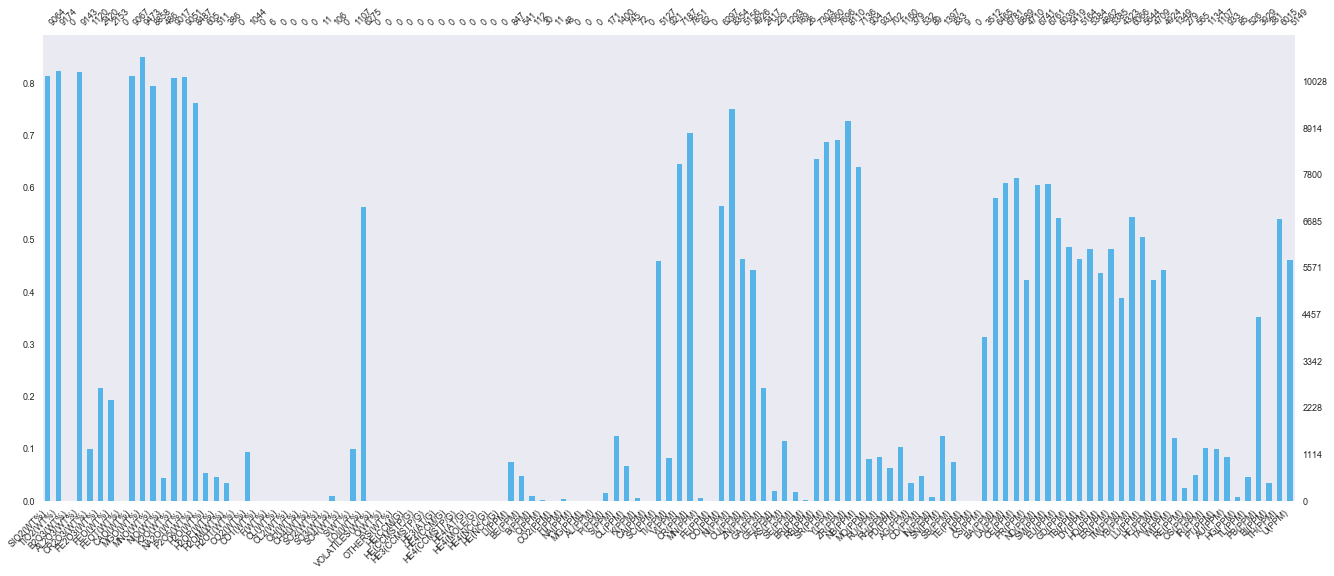

In [1576]:
msno.bar(df[col_interval],figsize=(20,8),color=default_color,fontsize=9,labels=True)

#### Listar quantos valores estão presentes em cada coluna

In [1577]:
with pd.option_context('display.max_rows', 200):
    display(df[col_interval].count())

SIO2(WT%)         9064
TIO2(WT%)         9174
B2O3(WT%)            0
AL2O3(WT%)        9143
CR2O3(WT%)        1120
FE2O3(WT%)        2420
FEO(WT%)          2153
FEOT(WT%)            0
CAO(WT%)          9067
MGO(WT%)          9473
MNO(WT%)          8858
NIO(WT%)           486
K2O(WT%)          9017
NA2O(WT%)         9051
P2O5(WT%)         8487
H2O(WT%)           605
H2OP(WT%)          511
H2OM(WT%)          386
H2OT(WT%)            0
CO2(WT%)          1044
CO1(WT%)             0
F(WT%)               6
CL(WT%)              0
CL2(WT%)             0
OH(WT%)              0
CH4(WT%)             0
SO2(WT%)            11
SO3(WT%)           106
SO4(WT%)             0
S(WT%)            1107
LOI(WT%)          6275
VOLATILES(WT%)       0
O(WT%)               0
OTHERS(WT%)          0
HE(CCM/G)            0
HE(CCMSTP/G)         0
HE3(CCMSTP/G)        0
HE3(AT/G)            0
HE4(CCM/G)           0
HE4(CCMSTP/G)        0
HE4(AT/G)            0
HE4(MOLE/G)          0
HE4(NCC/G)           0
HE(NCC/G)  

#### Criar lista com colunas sem dados (count = 0)

In [1578]:
no_data_cols = df[col_interval].count()[df[col_interval].count() == 0].index.values
no_data_cols

array(['B2O3(WT%)', 'FEOT(WT%)', 'H2OT(WT%)', 'CO1(WT%)', 'CL(WT%)', 'CL2(WT%)', 'OH(WT%)', 'CH4(WT%)', 'SO4(WT%)',
       'VOLATILES(WT%)', 'O(WT%)', 'OTHERS(WT%)', 'HE(CCM/G)', 'HE(CCMSTP/G)', 'HE3(CCMSTP/G)', 'HE3(AT/G)',
       'HE4(CCM/G)', 'HE4(CCMSTP/G)', 'HE4(AT/G)', 'HE4(MOLE/G)', 'HE4(NCC/G)', 'HE(NCC/G)', 'NA(PPM)', 'MG(PPM)',
       'AL(PPM)', 'CA(PPM)', 'FE(PPM)', 'I(PPM)'], dtype=object)

#### Criar lista com colunas que apresentam count < 1000

In [1579]:
lt_1000_data_cols = df[col_interval].count()[(df[col_interval].count() < 1000) & (df[col_interval].count() > 0)].index.values
lt_1000_data_cols

array(['NIO(WT%)', 'H2O(WT%)', 'H2OP(WT%)', 'H2OM(WT%)', 'F(WT%)', 'SO2(WT%)', 'SO3(WT%)', 'LI(PPM)', 'BE(PPM)',
       'B(PPM)', 'C(PPM)', 'CO2(PPM)', 'F(PPM)', 'P(PPM)', 'CL(PPM)', 'K(PPM)', 'TI(PPM)', 'MN(PPM)', 'GE(PPM)',
       'SE(PPM)', 'BR(PPM)', 'MO(PPM)', 'RU(PPM)', 'RH(PPM)', 'AG(PPM)', 'CD(PPM)', 'IN(PPM)', 'SB(PPM)', 'TE(PPM)',
       'RE(PPM)', 'OS(PPM)', 'AU(PPM)', 'HG(PPM)', 'TL(PPM)', 'BI(PPM)'], dtype=object)

#### Concatenar as listas criadas com a lista anterior de colunas a se remover

In [1580]:
remove_columns = np.concatenate((remove_columns,no_data_cols,lt_1000_data_cols), axis=0)
remove_columns

array(['CITATIONS', 'TECTONIC SETTING', 'LOCATION', 'LOCATION COMMENT', 'LATITUDE MIN', 'LATITUDE MAX', 'LONGITUDE MIN',
       'LONGITUDE MAX', 'LAND OR SEA', 'ELEVATION MIN', 'ELEVATION MAX', 'SAMPLE NAME', 'MIN. AGE (YRS.)',
       'MAX. AGE (YRS.)', 'GEOL.', 'AGE', 'ERUPTION DAY', 'ERUPTION MONTH', 'ERUPTION YEAR', 'ROCK TEXTURE',
       'ROCK TYPE', 'DRILL DEPTH MIN', 'DRILL DEPTHAX', 'ALTERATION', 'MINERAL', 'MATERIAL', 'ND143_ND144',
       'ND143_ND144_INI', 'EPSILON_ND', 'SR87_SR86', 'SR87_SR86_INI', 'PB206_PB204', 'PB206_PB204_INI', 'PB207_PB204',
       'PB207_PB204_INI', 'PB208_PB204', 'PB208_PB204_INI', 'OS184_OS188', 'OS186_OS188', 'OS187_OS186', 'OS187_OS188',
       'RE187_OS186', 'RE187_OS188', 'HF176_HF177', 'HE3_HE4', 'HE3_HE4(R/R(A))', 'HE4_HE3', 'HE4_HE3(R/R(A))',
       'K40_AR40', 'AR40_K40', 'UNIQUE_ID', 'Unnamed: 171', 'B2O3(WT%)', 'FEOT(WT%)', 'H2OT(WT%)', 'CO1(WT%)',
       'CL(WT%)', 'CL2(WT%)', 'OH(WT%)', 'CH4(WT%)', 'SO4(WT%)', 'VOLATILES(WT%)', 'O(WT%)', 

#### Recalcular meta_data e variaveis de listas de colunas

In [1581]:
meta_data = get_meta(df,remove_columns)
with pd.option_context('display.max_rows', 200):
    display(meta_data)

role     level   keep    dtype
varname                                           
CITATIONS          input    string  False   object
TECTONIC SETTING   input    string  False   object
LOCATION           input    string  False   object
LOCATION COMMENT   input    string  False   object
LATITUDE MIN       input  interval  False  float64
LATITUDE MAX       input  interval  False  float64
LONGITUDE MIN      input  interval  False  float64
LONGITUDE MAX      input  interval  False  float64
LAND OR SEA        input    string  False   object
ELEVATION MIN      input  interval  False  float64
ELEVATION MAX      input  interval  False  float64
SAMPLE NAME        input    string  False   object
ROCK NAME         target    string   True   object
MIN. AGE (YRS.)    input    string  False   object
MAX. AGE (YRS.)    input    string  False   object
GEOL.              input    string  False   object
AGE                input    string  False   object
ERUPTION DAY       input  interval  False  float64
ERUPTION MONTH     input  interval  False  float64
ERUPTION YEAR      input  interval  False  float64
ROCK TEXTURE       input    string  False   object
ROCK TYPE          input    string  False   object
DRILL DEPTH MIN    input  interval  False  float64
DRILL DEPTHAX      input  interval  False  float64
ALTERATION         input    string  False   object
MINERAL            input    string  False   object
MATERIAL           input    string  False   object
SIO2(WT%)          input  interval   True  float64
TIO2(WT%)          input  interval   True  float64
B2O3(WT%)          input  interval  False  float64
AL2O3(WT%)         input  interval   True  float64
CR2O3(WT%)         input  interval   True  float64
FE2O3(WT%)         input  interval   True  float64
FEO(WT%)           input  interval   True  float64
FEOT(WT%)          input  interval  False  float64
CAO(WT%)           input  interval   True  float64
MGO(WT%)           input  interval   True  float64
MNO(WT%)           input  interval   True  float64
NIO(WT%)           input  interval  False  float64
K2O(WT%)           input  interval   True  float64
NA2O(WT%)          input  interval   True  float64
P2O5(WT%)          input  interval   True  float64
H2O(WT%)           input  interval  False  float64
H2OP(WT%)          input  interval  False  float64
H2OM(WT%)          input  interval  False  float64
H2OT(WT%)          input  interval  False  float64
CO2(WT%)           input  interval   True  float64
CO1(WT%)           input  interval  False  float64
F(WT%)             input  interval  False  float64
CL(WT%)            input  interval  False  float64
CL2(WT%)           input  interval  False  float64
OH(WT%)            input  interval  False  float64
CH4(WT%)           input  interval  False  float64
SO2(WT%)           input  interval  False  float64
SO3(WT%)           input  interval  False  float64
SO4(WT%)           input  interval  False  float64
S(WT%)             input  interval   True  float64
LOI(WT%)           input  interval   True  float64
VOLATILES(WT%)     input  interval  False  float64
O(WT%)             input  interval  False  float64
OTHERS(WT%)        input  interval  False  float64
HE(CCM/G)          input  interval  False  float64
HE(CCMSTP/G)       input  interval  False  float64
HE3(CCMSTP/G)      input  interval  False  float64
HE3(AT/G)          input  interval  False  float64
HE4(CCM/G)         input  interval  False  float64
HE4(CCMSTP/G)      input  interval  False  float64
HE4(AT/G)          input  interval  False  float64
HE4(MOLE/G)        input  interval  False  float64
HE4(NCC/G)         input  interval  False  float64
HE(NCC/G)          input  interval  False  float64
LI(PPM)            input  interval  False  float64
BE(PPM)            input  interval  False  float64
B(PPM)             input  interval  False  float64
C(PPM)             input  interval  False  float64
CO2(PPM)           input  interval  False  float64
F(PPM)             input  interval  False 

In [1582]:
col_interval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_target = meta_data[(meta_data.role == 'target')].index
display(col_interval.values)
display(col_target.values)

array(['SIO2(WT%)', 'TIO2(WT%)', 'AL2O3(WT%)', 'CR2O3(WT%)', 'FE2O3(WT%)', 'FEO(WT%)', 'CAO(WT%)', 'MGO(WT%)',
       'MNO(WT%)', 'K2O(WT%)', 'NA2O(WT%)', 'P2O5(WT%)', 'CO2(WT%)', 'S(WT%)', 'LOI(WT%)', 'S(PPM)', 'SC(PPM)',
       'V(PPM)', 'CR(PPM)', 'CO(PPM)', 'NI(PPM)', 'CU(PPM)', 'ZN(PPM)', 'GA(PPM)', 'AS(PPM)', 'RB(PPM)', 'SR(PPM)',
       'Y(PPM)', 'ZR(PPM)', 'NB(PPM)', 'PD(PPM)', 'SN(PPM)', 'CS(PPM)', 'BA(PPM)', 'LA(PPM)', 'CE(PPM)', 'PR(PPM)',
       'ND(PPM)', 'SM(PPM)', 'EU(PPM)', 'GD(PPM)', 'TB(PPM)', 'DY(PPM)', 'HO(PPM)', 'ER(PPM)', 'TM(PPM)', 'YB(PPM)',
       'LU(PPM)', 'HF(PPM)', 'TA(PPM)', 'W(PPM)', 'IR(PPM)', 'PT(PPM)', 'PB(PPM)', 'TH(PPM)', 'U(PPM)'], dtype=object)

array(['ROCK NAME'], dtype=object)

#### Listar contagem de valores em cada coluna

In [1583]:
with pd.option_context('display.max_rows', 200):
    display(df[col_interval].count())

SIO2(WT%)     9064
TIO2(WT%)     9174
AL2O3(WT%)    9143
CR2O3(WT%)    1120
FE2O3(WT%)    2420
FEO(WT%)      2153
CAO(WT%)      9067
MGO(WT%)      9473
MNO(WT%)      8858
K2O(WT%)      9017
NA2O(WT%)     9051
P2O5(WT%)     8487
CO2(WT%)      1044
S(WT%)        1107
LOI(WT%)      6275
S(PPM)        1400
SC(PPM)       5127
V(PPM)        7187
CR(PPM)       7851
CO(PPM)       6297
NI(PPM)       8354
CU(PPM)       5156
ZN(PPM)       4926
GA(PPM)       2417
AS(PPM)       1293
RB(PPM)       7303
SR(PPM)       7660
Y(PPM)        7696
ZR(PPM)       8110
NB(PPM)       7136
PD(PPM)       1160
SN(PPM)       1397
CS(PPM)       3512
BA(PPM)       6465
LA(PPM)       6781
CE(PPM)       6889
PR(PPM)       4710
ND(PPM)       6741
SM(PPM)       6761
EU(PPM)       6039
GD(PPM)       5419
TB(PPM)       5164
DY(PPM)       5384
HO(PPM)       4862
ER(PPM)       5385
TM(PPM)       4323
YB(PPM)       6066
LU(PPM)       5644
HF(PPM)       4709
TA(PPM)       4924
W(PPM)        1349
IR(PPM)       1134
PT(PPM)     

#### Plotar missings em cada coluna

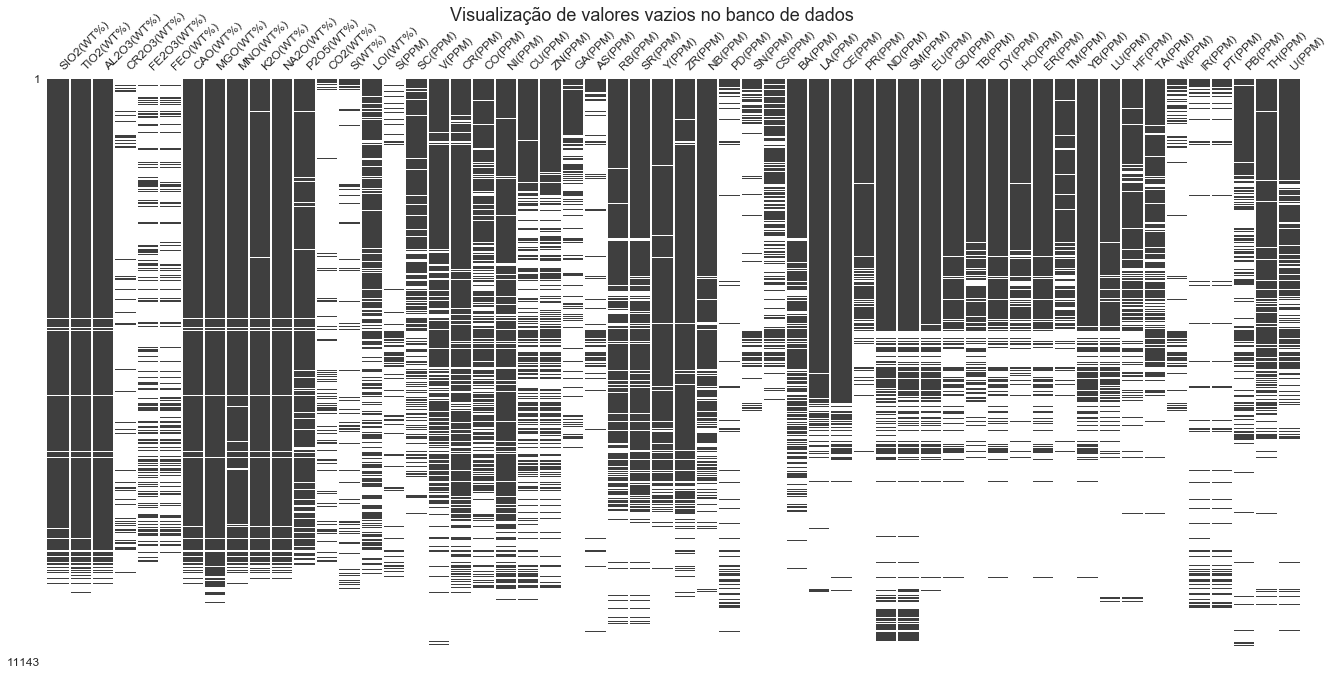

In [1584]:
#msno.dendrogram(df[col_interval],figsize=(20,20),fontsize=10)
sorted_data = msno.nullity_sort(df[col_interval], sort='descending') # or sort='ascending'
ms_plt = msno.matrix(sorted_data,figsize=(20,10),fontsize=12,labels=True, inline=False, sparkline=False)

ms_plt.suptitle(u'Visualização de valores vazios no banco de dados', fontsize=18)
ms_plt.axes[0].tick_params(axis='y', labelsize=12)
ms_plt.savefig('imgs/Fig_2.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')

#### Criar lista com colunas que apresentam valores esparsos

In [1585]:
sparse_data_columns = np.array(['CR2O3(WT%)','FE2O3(WT%)','FEO(WT%)',
                       'CO2(WT%)','S(WT%)','S(PPM)',
                       'GA(PPM)','AS(PPM)','PD(PPM)',
                       'SN(PPM)','CS(PPM)','W(PPM)', 'IR(PPM)',
                      'PT(PPM)','PB(PPM)'])
sparse_data_columns

array(['CR2O3(WT%)', 'FE2O3(WT%)', 'FEO(WT%)', 'CO2(WT%)', 'S(WT%)', 'S(PPM)', 'GA(PPM)', 'AS(PPM)', 'PD(PPM)',
       'SN(PPM)', 'CS(PPM)', 'W(PPM)', 'IR(PPM)', 'PT(PPM)', 'PB(PPM)'], 
      dtype='|S10')

#### Concatenar a lista anterior

In [1586]:
remove_columns = np.concatenate((remove_columns,sparse_data_columns), axis=0)
remove_columns

array(['CITATIONS', 'TECTONIC SETTING', 'LOCATION', 'LOCATION COMMENT', 'LATITUDE MIN', 'LATITUDE MAX', 'LONGITUDE MIN',
       'LONGITUDE MAX', 'LAND OR SEA', 'ELEVATION MIN', 'ELEVATION MAX', 'SAMPLE NAME', 'MIN. AGE (YRS.)',
       'MAX. AGE (YRS.)', 'GEOL.', 'AGE', 'ERUPTION DAY', 'ERUPTION MONTH', 'ERUPTION YEAR', 'ROCK TEXTURE',
       'ROCK TYPE', 'DRILL DEPTH MIN', 'DRILL DEPTHAX', 'ALTERATION', 'MINERAL', 'MATERIAL', 'ND143_ND144',
       'ND143_ND144_INI', 'EPSILON_ND', 'SR87_SR86', 'SR87_SR86_INI', 'PB206_PB204', 'PB206_PB204_INI', 'PB207_PB204',
       'PB207_PB204_INI', 'PB208_PB204', 'PB208_PB204_INI', 'OS184_OS188', 'OS186_OS188', 'OS187_OS186', 'OS187_OS188',
       'RE187_OS186', 'RE187_OS188', 'HF176_HF177', 'HE3_HE4', 'HE3_HE4(R/R(A))', 'HE4_HE3', 'HE4_HE3(R/R(A))',
       'K40_AR40', 'AR40_K40', 'UNIQUE_ID', 'Unnamed: 171', 'B2O3(WT%)', 'FEOT(WT%)', 'H2OT(WT%)', 'CO1(WT%)',
       'CL(WT%)', 'CL2(WT%)', 'OH(WT%)', 'CH4(WT%)', 'SO4(WT%)', 'VOLATILES(WT%)', 'O(WT%)', 

#### Atualizar meta_data

In [1587]:
meta_data = get_meta(df,remove_columns)
with pd.option_context('display.max_rows', 200):
    display(meta_data)

role     level   keep    dtype
varname                                           
CITATIONS          input    string  False   object
TECTONIC SETTING   input    string  False   object
LOCATION           input    string  False   object
LOCATION COMMENT   input    string  False   object
LATITUDE MIN       input  interval  False  float64
LATITUDE MAX       input  interval  False  float64
LONGITUDE MIN      input  interval  False  float64
LONGITUDE MAX      input  interval  False  float64
LAND OR SEA        input    string  False   object
ELEVATION MIN      input  interval  False  float64
ELEVATION MAX      input  interval  False  float64
SAMPLE NAME        input    string  False   object
ROCK NAME         target    string   True   object
MIN. AGE (YRS.)    input    string  False   object
MAX. AGE (YRS.)    input    string  False   object
GEOL.              input    string  False   object
AGE                input    string  False   object
ERUPTION DAY       input  interval  False  float64
ERUPTION MONTH     input  interval  False  float64
ERUPTION YEAR      input  interval  False  float64
ROCK TEXTURE       input    string  False   object
ROCK TYPE          input    string  False   object
DRILL DEPTH MIN    input  interval  False  float64
DRILL DEPTHAX      input  interval  False  float64
ALTERATION         input    string  False   object
MINERAL            input    string  False   object
MATERIAL           input    string  False   object
SIO2(WT%)          input  interval   True  float64
TIO2(WT%)          input  interval   True  float64
B2O3(WT%)          input  interval  False  float64
AL2O3(WT%)         input  interval   True  float64
CR2O3(WT%)         input  interval  False  float64
FE2O3(WT%)         input  interval  False  float64
FEO(WT%)           input  interval  False  float64
FEOT(WT%)          input  interval  False  float64
CAO(WT%)           input  interval   True  float64
MGO(WT%)           input  interval   True  float64
MNO(WT%)           input  interval   True  float64
NIO(WT%)           input  interval  False  float64
K2O(WT%)           input  interval   True  float64
NA2O(WT%)          input  interval   True  float64
P2O5(WT%)          input  interval   True  float64
H2O(WT%)           input  interval  False  float64
H2OP(WT%)          input  interval  False  float64
H2OM(WT%)          input  interval  False  float64
H2OT(WT%)          input  interval  False  float64
CO2(WT%)           input  interval  False  float64
CO1(WT%)           input  interval  False  float64
F(WT%)             input  interval  False  float64
CL(WT%)            input  interval  False  float64
CL2(WT%)           input  interval  False  float64
OH(WT%)            input  interval  False  float64
CH4(WT%)           input  interval  False  float64
SO2(WT%)           input  interval  False  float64
SO3(WT%)           input  interval  False  float64
SO4(WT%)           input  interval  False  float64
S(WT%)             input  interval  False  float64
LOI(WT%)           input  interval   True  float64
VOLATILES(WT%)     input  interval  False  float64
O(WT%)             input  interval  False  float64
OTHERS(WT%)        input  interval  False  float64
HE(CCM/G)          input  interval  False  float64
HE(CCMSTP/G)       input  interval  False  float64
HE3(CCMSTP/G)      input  interval  False  float64
HE3(AT/G)          input  interval  False  float64
HE4(CCM/G)         input  interval  False  float64
HE4(CCMSTP/G)      input  interval  False  float64
HE4(AT/G)          input  interval  False  float64
HE4(MOLE/G)        input  interval  False  float64
HE4(NCC/G)         input  interval  False  float64
HE(NCC/G)          input  interval  False  float64
LI(PPM)            input  interval  False  float64
BE(PPM)            input  interval  False  float64
B(PPM)             input  interval  False  float64
C(PPM)             input  interval  False  float64
CO2(PPM)           input  interval  False  float64
F(PPM)             input  interval  False 

In [1588]:
col_interval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_target = meta_data[(meta_data.role == 'target')].index
display(col_interval.values)
display(col_target.values)

array(['SIO2(WT%)', 'TIO2(WT%)', 'AL2O3(WT%)', 'CAO(WT%)', 'MGO(WT%)', 'MNO(WT%)', 'K2O(WT%)', 'NA2O(WT%)', 'P2O5(WT%)',
       'LOI(WT%)', 'SC(PPM)', 'V(PPM)', 'CR(PPM)', 'CO(PPM)', 'NI(PPM)', 'CU(PPM)', 'ZN(PPM)', 'RB(PPM)', 'SR(PPM)',
       'Y(PPM)', 'ZR(PPM)', 'NB(PPM)', 'BA(PPM)', 'LA(PPM)', 'CE(PPM)', 'PR(PPM)', 'ND(PPM)', 'SM(PPM)', 'EU(PPM)',
       'GD(PPM)', 'TB(PPM)', 'DY(PPM)', 'HO(PPM)', 'ER(PPM)', 'TM(PPM)', 'YB(PPM)', 'LU(PPM)', 'HF(PPM)', 'TA(PPM)',
       'TH(PPM)', 'U(PPM)'], dtype=object)

array(['ROCK NAME'], dtype=object)

#### Plotar missings por coluna

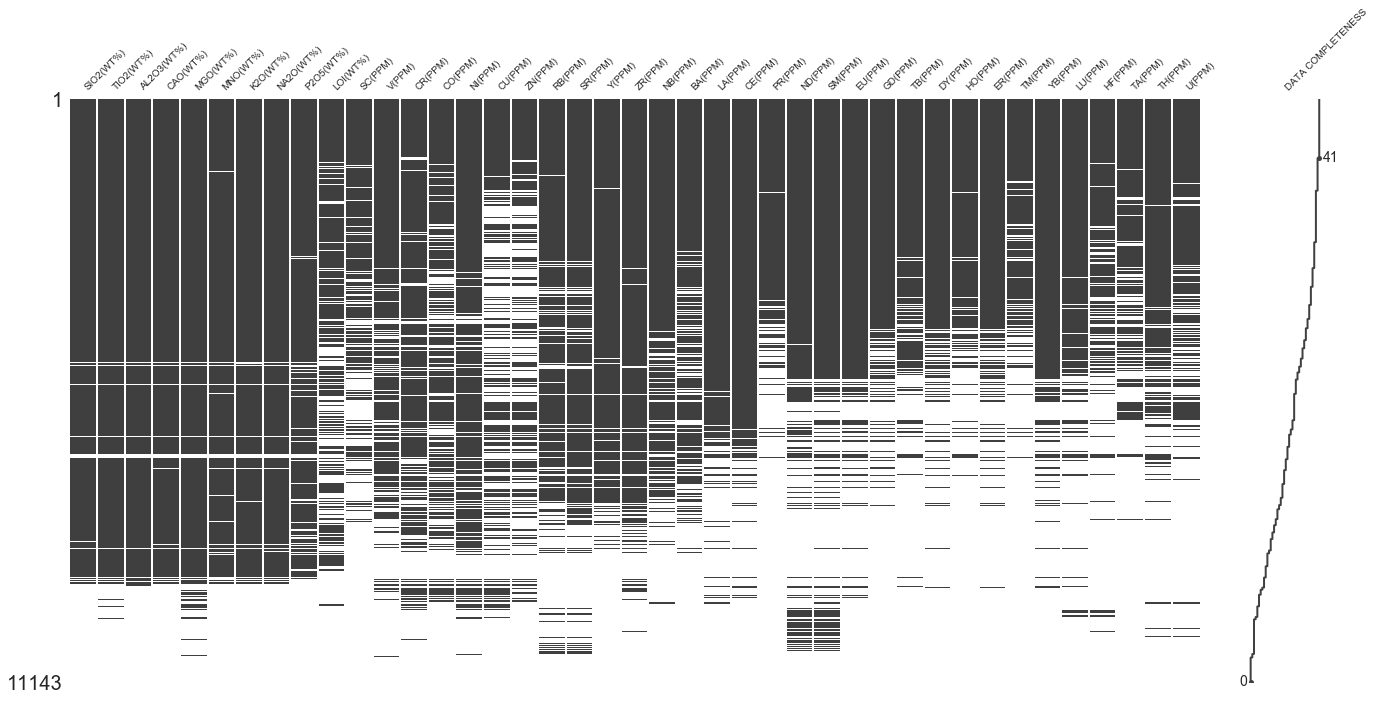

In [1589]:
#msno.dendrogram(df[col_interval],figsize=(20,20),fontsize=10)
sorted_data = msno.nullity_sort(df[col_interval], sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,10),fontsize=10,labels=True)

#### Remover linhas sem análises de SIO2

In [1590]:
df = df.drop(df[col_interval][pd.isnull(df['SIO2(WT%)']) == True].index,axis=0)
df[col_interval].shape

(9064, 41)

#### Remover linhas com mais de 30% das colunas com missing

In [1591]:
df = df.drop(df[col_interval][df[col_interval].isnull().sum(axis=1) > df[col_interval].shape[1]*0.3].index,axis=0)
df[col_interval].shape

(5191, 41)

#### Remover espaços do final das strings da variavel alvo

In [1592]:
df['ROCK NAME'] = df['ROCK NAME'].apply(lambda x: x.rstrip())

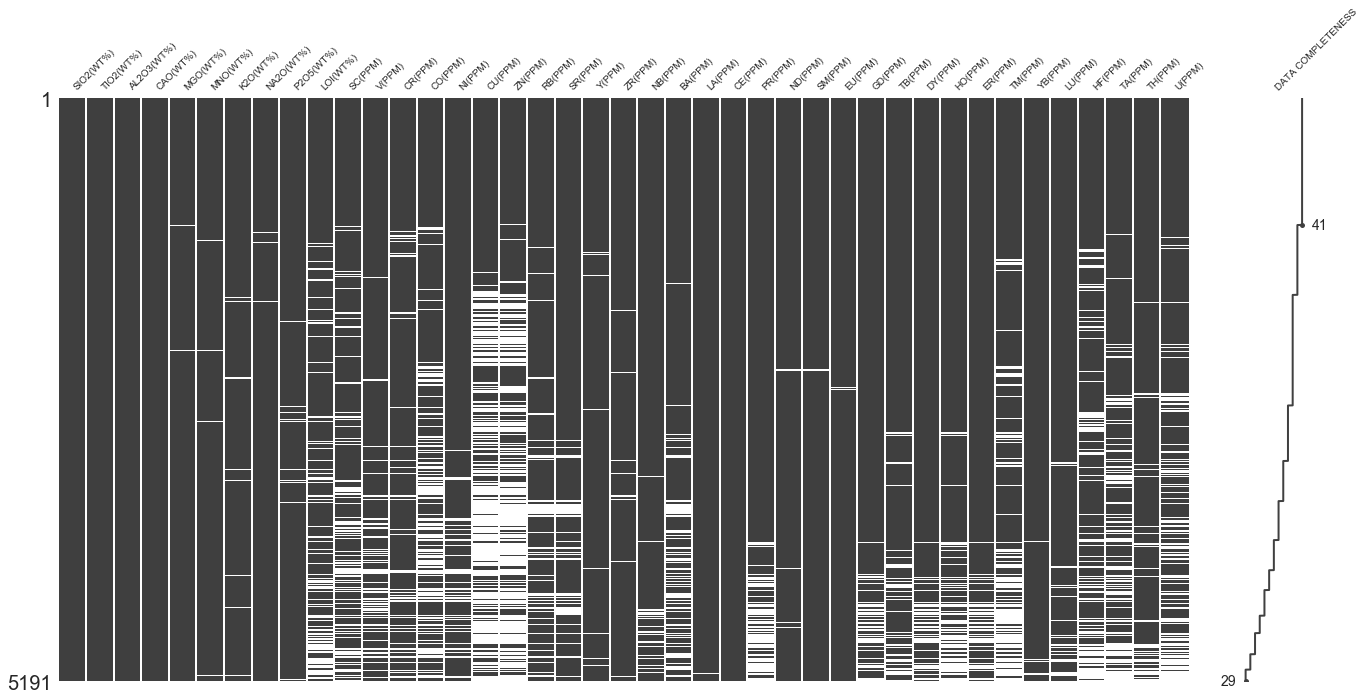

In [1593]:
#msno.dendrogram(df[col_interval],figsize=(20,20),fontsize=10)
sorted_data = msno.nullity_sort(df[col_interval], sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,10),fontsize=10,labels=True)

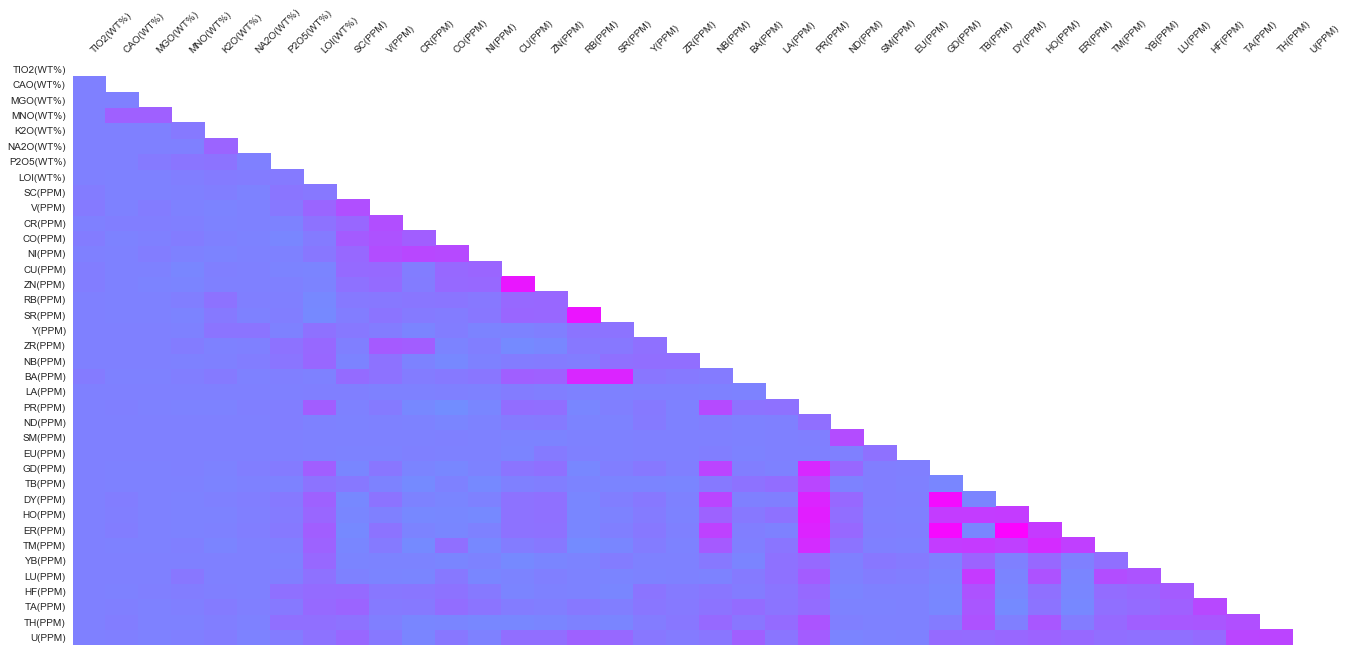

In [1594]:
msno.heatmap(df[col_interval],figsize=(20,10),cmap=colormap,labels=False, fontsize=10)

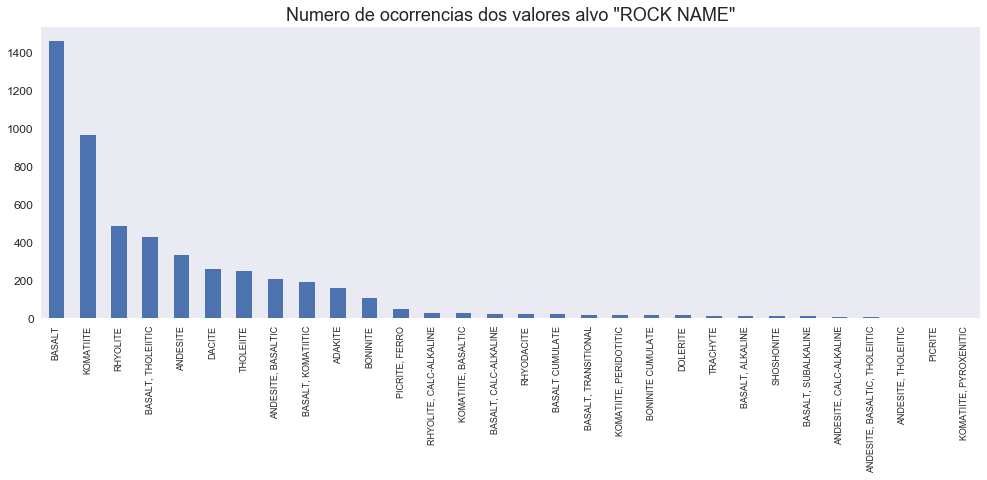

In [1595]:
target = df['ROCK NAME']

plt.figure(figsize=(15,5))
plt.xticks(fontsize=9)

ax = df['ROCK NAME'].value_counts().plot(kind = 'bar', title= 'Numero de ocorrencias dos valores alvo "ROCK NAME"')
#ax = sns.countplot('ROCK NAME',data=df,color=default_color, order = target.value_counts().index)
#ax.set(xticklabels=[])

plt.show()

In [1596]:
target_names = df['ROCK NAME'].unique()
print 'Total de valores alvo unicos:  %d' % len(target_names)

target_names.sort()
print '\n'.join([ e for e in target_names ])

Total de valores alvo unicos:  30
ADAKITE
ANDESITE
ANDESITE, BASALTIC
ANDESITE, BASALTIC, THOLEIITIC
ANDESITE, CALC-ALKALINE
ANDESITE, THOLEIITIC
BASALT
BASALT CUMULATE
BASALT, ALKALINE
BASALT, CALC-ALKALINE
BASALT, KOMATIITIC
BASALT, SUBALKALINE
BASALT, THOLEIITIC
BASALT, TRANSITIONAL
BONINITE
BONINITE CUMULATE
DACITE
DOLERITE
KOMATIITE
KOMATIITE, BASALTIC
KOMATIITE, PERIDOTITIC
KOMATIITE, PYROXENITIC
PICRITE
PICRITE, FERRO
RHYODACITE
RHYOLITE
RHYOLITE, CALC-ALKALINE
SHOSHONITE
THOLEIITE
TRACHYTE


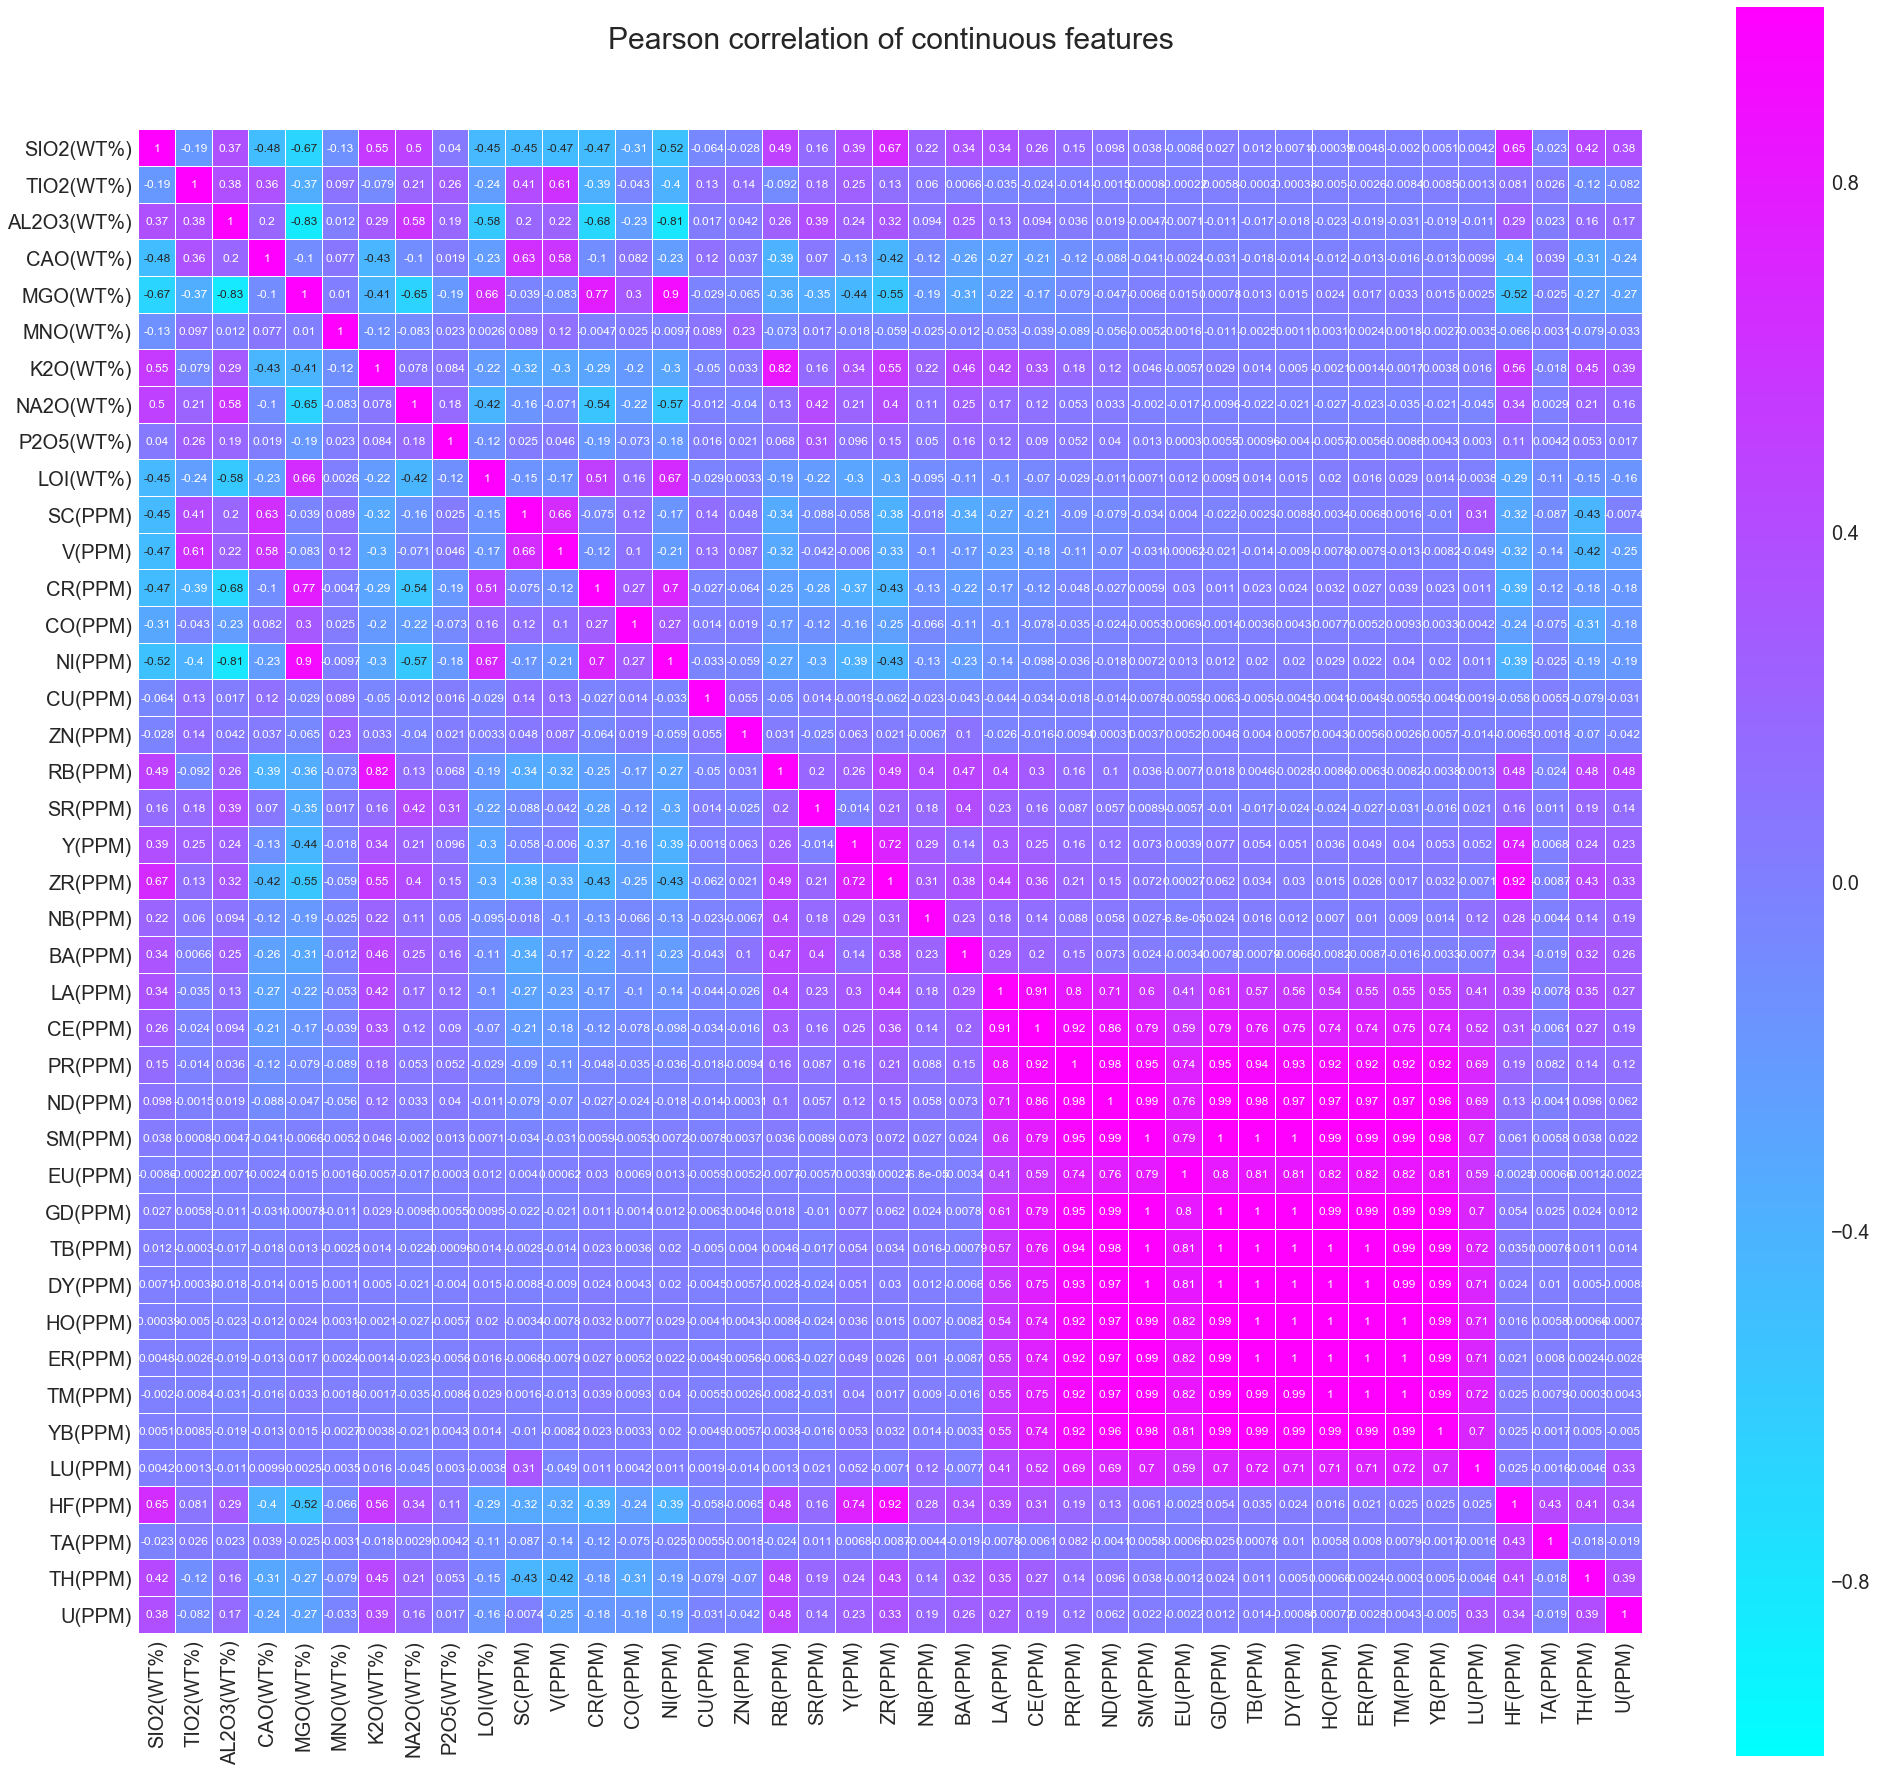

In [1597]:
sns.set(font_scale=2)
plt.figure(figsize=(30,30))
plt.title('Pearson correlation of continuous features', y=1.05, size=30)

sns.heatmap(df[col_interval].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', 
            annot=True, annot_kws={"size": 12})
#Correlação apenas das variaveis Intervalo , não se deve fazer em binarios ou nominais
plt.show()

#### Preencher Missings utilizando a média dos valores da coluna agrupados pela variável alvo

Criado data frame com média dos valores agrupados pelo 'ROCK NAME'

In [1598]:
df[col_interval].shape

(5191, 41)

In [1599]:
df_mean_interval_gb_RN = df[np.concatenate((col_interval,col_target),axis=0)].groupby(['ROCK NAME']).mean()
df_mean_interval_gb_RN

SIO2(WT%)  TIO2(WT%)  AL2O3(WT%)  CAO(WT%)  \
ROCK NAME                                                                    
ADAKITE                             67.83       0.40       15.73      3.26   
ANDESITE                            59.53       0.83       15.07      5.93   
ANDESITE, BASALTIC                  54.32       0.95       14.19      8.15   
ANDESITE, BASALTIC, THOLEIITIC      53.32       0.84       15.92     10.82   
ANDESITE, CALC-ALKALINE             57.32       1.06       16.52      6.27   
ANDESITE, THOLEIITIC                58.45       1.20       14.55      6.16   
BASALT                              50.61       0.99       13.69      9.68   
BASALT CUMULATE                     38.01       0.20        4.07      1.10   
BASALT, ALKALINE                    45.05       2.22       12.13      9.07   
BASALT, CALC-ALKALINE               50.70       0.73       15.95      9.67   
BASALT, KOMATIITIC                  50.14       0.73       11.32      9.09   
BASALT, SUBALKALINE                 50.08       0.78       14.08      9.48   
BASALT, THOLEIITIC                  50.58       1.12       14.33      9.91   
BASALT, TRANSITIONAL                50.52       2.00       14.46      8.78   
BONINITE                            50.13       0.32       12.80      7.75   
BONINITE CUMULATE                   39.86       0.06        5.46      1.88   
DACITE                              66.22       0.60       15.02      3.21   
DOLERITE                            50.17       1.13       14.10      9.69   
KOMATIITE                           44.82       0.33        5.97      5.62   
KOMATIITE, BASALTIC                 46.85       0.86        8.34      9.08   
KOMATIITE, PERIDOTITIC              43.77       0.32        3.82      4.09   
KOMATIITE, PYROXENITIC              39.30       0.37        7.10     10.00   
PICRITE                             47.95       0.71        8.72      9.98   
PICRITE, FERRO                      46.41       1.34        7.44      8.97   
RHYODACITE                          70.22       0.42       14.73      2.64   
RHYOLITE                            74.39       0.28       12.58      1.54   
RHYOLITE, CALC-ALKALINE             76.89       0.21       11.91      0.92   
SHOSHONITE                          57.92       1.23       18.39      3.23   
THOLEIITE                           49.94       1.06       14.13      9.92   
TRACHYTE                            54.19       0.77       17.24      5.57   

                                MGO(WT%)  MNO(WT%)  K2O(WT%)  NA2O(WT%)  \
ROCK NAME                                                                 
ADAKITE                             1.50      0.06      1.65       4.50   
ANDESITE                            4.04      0.16      1.71       3.03   
ANDESITE, BASALTIC                  5.96      0.44      1.33       2.20   
ANDESITE, BASALTIC, THOLEIITIC      5.01      0.20      0.15       2.67   
ANDESITE, CALC-ALKALINE             4.27      0.15      0.89       3.82   
ANDESITE, THOLEIITIC                3.69      0.18      0.76       1.75   
BASALT                              7.74      0.23      0.59       2.10   
BASALT CUMULATE                    32.60      0.16      0.01       0.01   
BASALT, ALKALINE                    9.36      0.16      2.61       3.01   
BASALT, CALC-ALKALINE               7.13      0.20      0.75       2.72   
BASALT, KOMATIITIC                 12.24      0.20      0.27       1.75   
BASALT, SUBALKALINE                 7.70      0.19      0.59       2.03   
BASALT, THOLEIITIC                  6.71      0.21      0.60       2.23   
BASALT, TRANSITIONAL                5.43      0.26      0.69       2.56   
BONINITE                           15.54      0.17      0.47       1.08   
BONINITE CUMULATE                  32.96      0.13      0.00       0.01   
DACITE                              2.13      0.08      2.23       3.50   
DOLERITE                            6.73      0.17      0.53       2.38   
KOMATIITE                          

Substituindo valores em branco pelas médias

In [1600]:

for col, val in df[col_interval].isnull().sum().iteritems():
    if val > 0:
        RN_arr = df.loc[df[col][df[col].isnull()].index]['ROCK NAME']
        for idx, rn in RN_arr.iteritems():
            df.loc[idx,col] = df_mean_interval_gb_RN.loc[rn,col]
       

Visualizar os missing dos dados após a operação

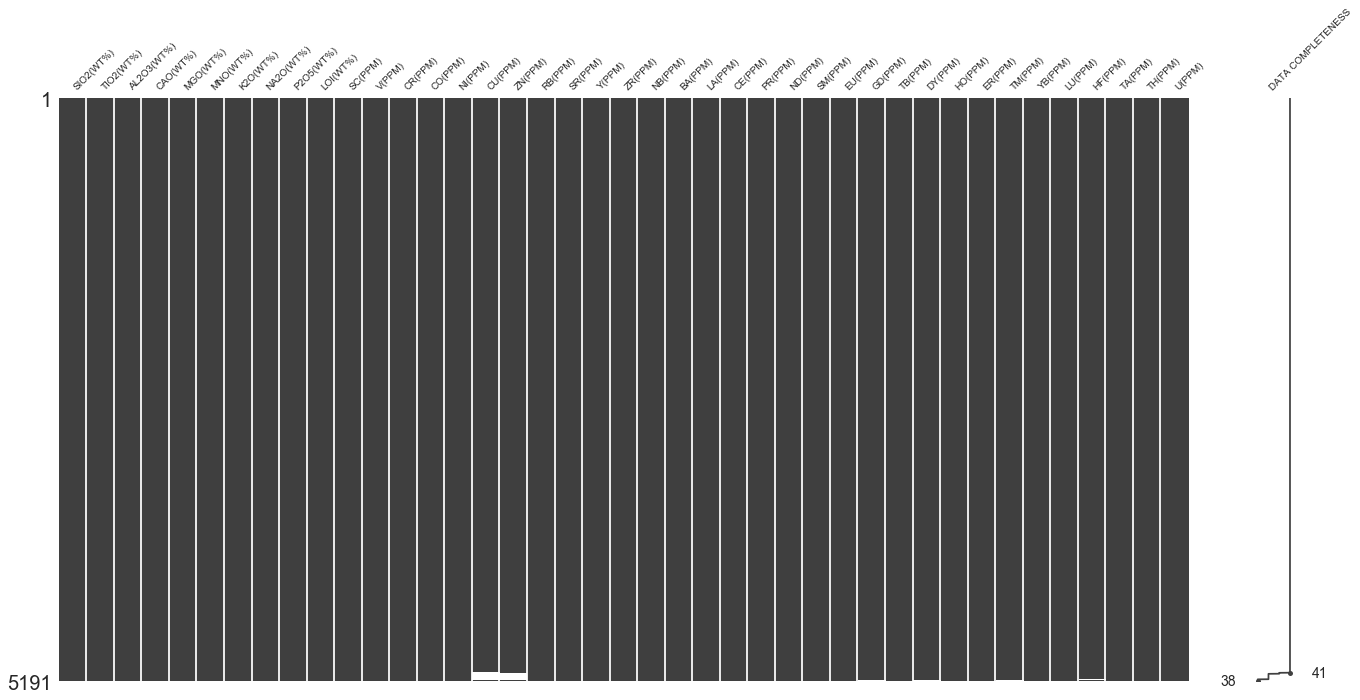

In [1601]:
#msno.dendrogram(df[col_interval],figsize=(20,20),fontsize=10)
sorted_data = msno.nullity_sort(df[col_interval], sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,10),fontsize=10,labels=True)

In [1602]:
df[col_interval].isnull().sum()

SIO2(WT%)      0
TIO2(WT%)      0
AL2O3(WT%)     0
CAO(WT%)       0
MGO(WT%)       0
MNO(WT%)       0
K2O(WT%)       0
NA2O(WT%)      0
P2O5(WT%)      0
LOI(WT%)       0
SC(PPM)        0
V(PPM)         0
CR(PPM)        0
CO(PPM)        0
NI(PPM)        0
CU(PPM)       62
ZN(PPM)       49
RB(PPM)        0
SR(PPM)        0
Y(PPM)         0
ZR(PPM)        0
NB(PPM)        0
BA(PPM)        0
LA(PPM)        0
CE(PPM)        0
PR(PPM)        0
ND(PPM)        0
SM(PPM)        0
EU(PPM)        0
GD(PPM)       15
TB(PPM)        0
DY(PPM)       15
HO(PPM)        0
ER(PPM)        0
TM(PPM)       19
YB(PPM)        0
LU(PPM)        0
HF(PPM)        4
TA(PPM)        0
TH(PPM)        0
U(PPM)         0
dtype: int64

#### Remover linhas que ainda apresentam missings

In [1603]:
df = df.drop(df[col_interval][df[col_interval].isnull().sum(axis=1) > 0].index,axis=0)
df[col_interval].shape

(5114, 41)

#### Removendo linhas com que apresentam a variavel alvo com menos de 10 ocorrencias

In [1604]:
target_gt_10 = [x for x in target.value_counts().index if target.value_counts()[x] >= 10]

with pd.option_context('display.max_rows', 200):
    print (target.value_counts()[target_gt_10])
    #print len(target.value_counts()[target_gt_10])

BASALT                     1465
KOMATIITE                   968
RHYOLITE                    489
BASALT, THOLEIITIC          427
ANDESITE                    334
DACITE                      261
THOLEIITE                   252
ANDESITE, BASALTIC          206
BASALT, KOMATIITIC          192
ADAKITE                     160
BONINITE                    110
PICRITE, FERRO               48
RHYOLITE, CALC-ALKALINE      30
KOMATIITE, BASALTIC          26
BASALT, CALC-ALKALINE        25
RHYODACITE                   25
BASALT CUMULATE              21
BASALT, TRANSITIONAL         18
KOMATIITE, PERIDOTITIC       17
BONINITE CUMULATE            17
DOLERITE                     17
TRACHYTE                     15
BASALT, ALKALINE             15
SHOSHONITE                   14
BASALT, SUBALKALINE          11
ANDESITE, CALC-ALKALINE      10
Name: ROCK NAME, dtype: int64


In [1605]:
df = df[df['ROCK NAME'].isin(target_gt_10)]
df.shape

(5113, 172)

In [1606]:
df[col_interval].shape

(5113, 41)

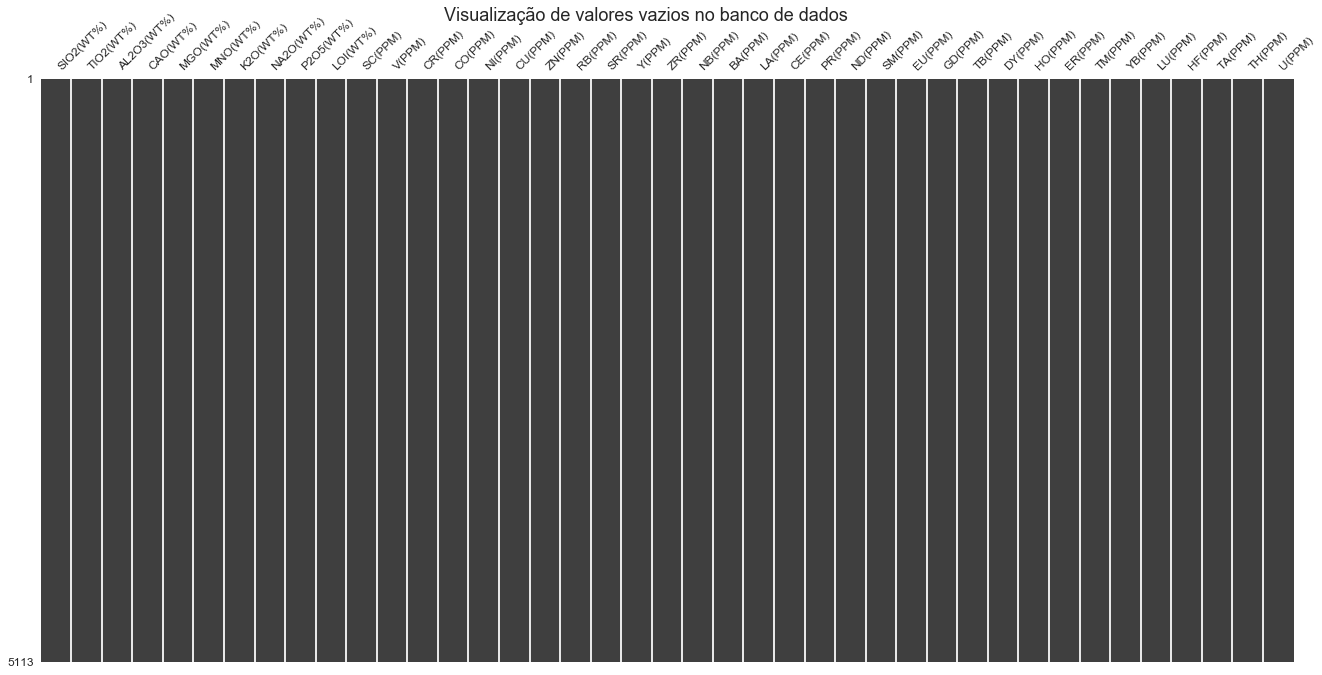

In [1607]:
#msno.dendrogram(df[col_interval],figsize=(20,20),fontsize=10)
sorted_data = msno.nullity_sort(df[col_interval], sort='descending') # or sort='ascending'
ms_plt = msno.matrix(sorted_data,figsize=(20,10),fontsize=12,labels=True, inline=False, sparkline=False)

ms_plt.suptitle(u'Visualização de valores vazios no banco de dados', fontsize=18)
ms_plt.axes[0].tick_params(axis='y', labelsize=12)
ms_plt.savefig('imgs/Fig_3.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')

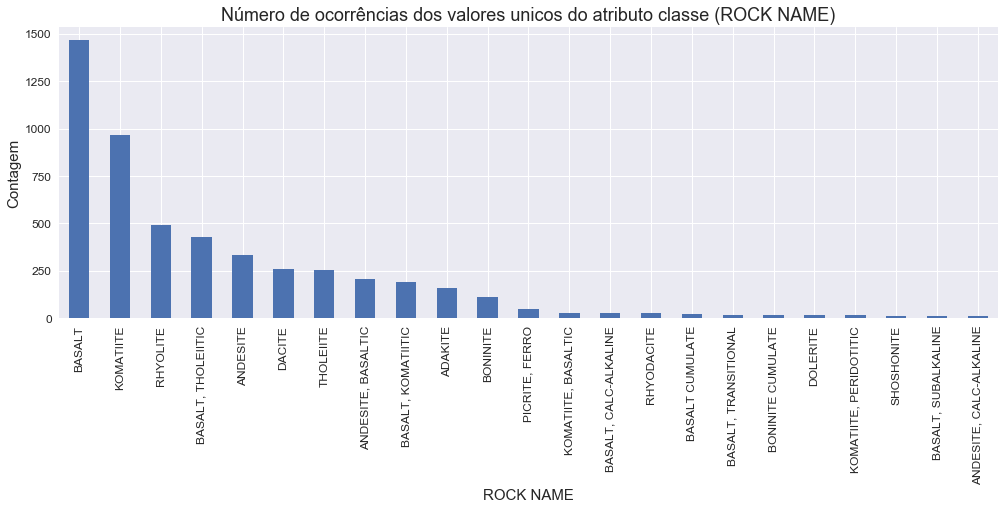

In [1608]:
target = df['ROCK NAME']

plt.figure(figsize=(15,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


ax = df['ROCK NAME'].value_counts().plot(kind = 'bar')
#ax = sns.countplot('ROCK NAME',data=df,color=default_color, order = target.value_counts().index)
#ax.set(xticklabels=[])
ax.set_title(u'Número de ocorrências dos valores unicos do atributo classe (ROCK NAME)',fontsize=18)
ax.set_xlabel('ROCK NAME',fontsize= 15)
ax.set_ylabel('Contagem',fontsize= 15)
plt.savefig('imgs/Fig_4.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')

plt.show()

In [1609]:
target_names = df['ROCK NAME'].unique()
print 'Total de valores alvo unicos:  %d' % len(target_names)

target_names.sort()
print '\n'.join([ e for e in target_names ])

Total de valores alvo unicos:  23
ADAKITE
ANDESITE
ANDESITE, BASALTIC
ANDESITE, CALC-ALKALINE
BASALT
BASALT CUMULATE
BASALT, CALC-ALKALINE
BASALT, KOMATIITIC
BASALT, SUBALKALINE
BASALT, THOLEIITIC
BASALT, TRANSITIONAL
BONINITE
BONINITE CUMULATE
DACITE
DOLERITE
KOMATIITE
KOMATIITE, BASALTIC
KOMATIITE, PERIDOTITIC
PICRITE, FERRO
RHYODACITE
RHYOLITE
SHOSHONITE
THOLEIITE


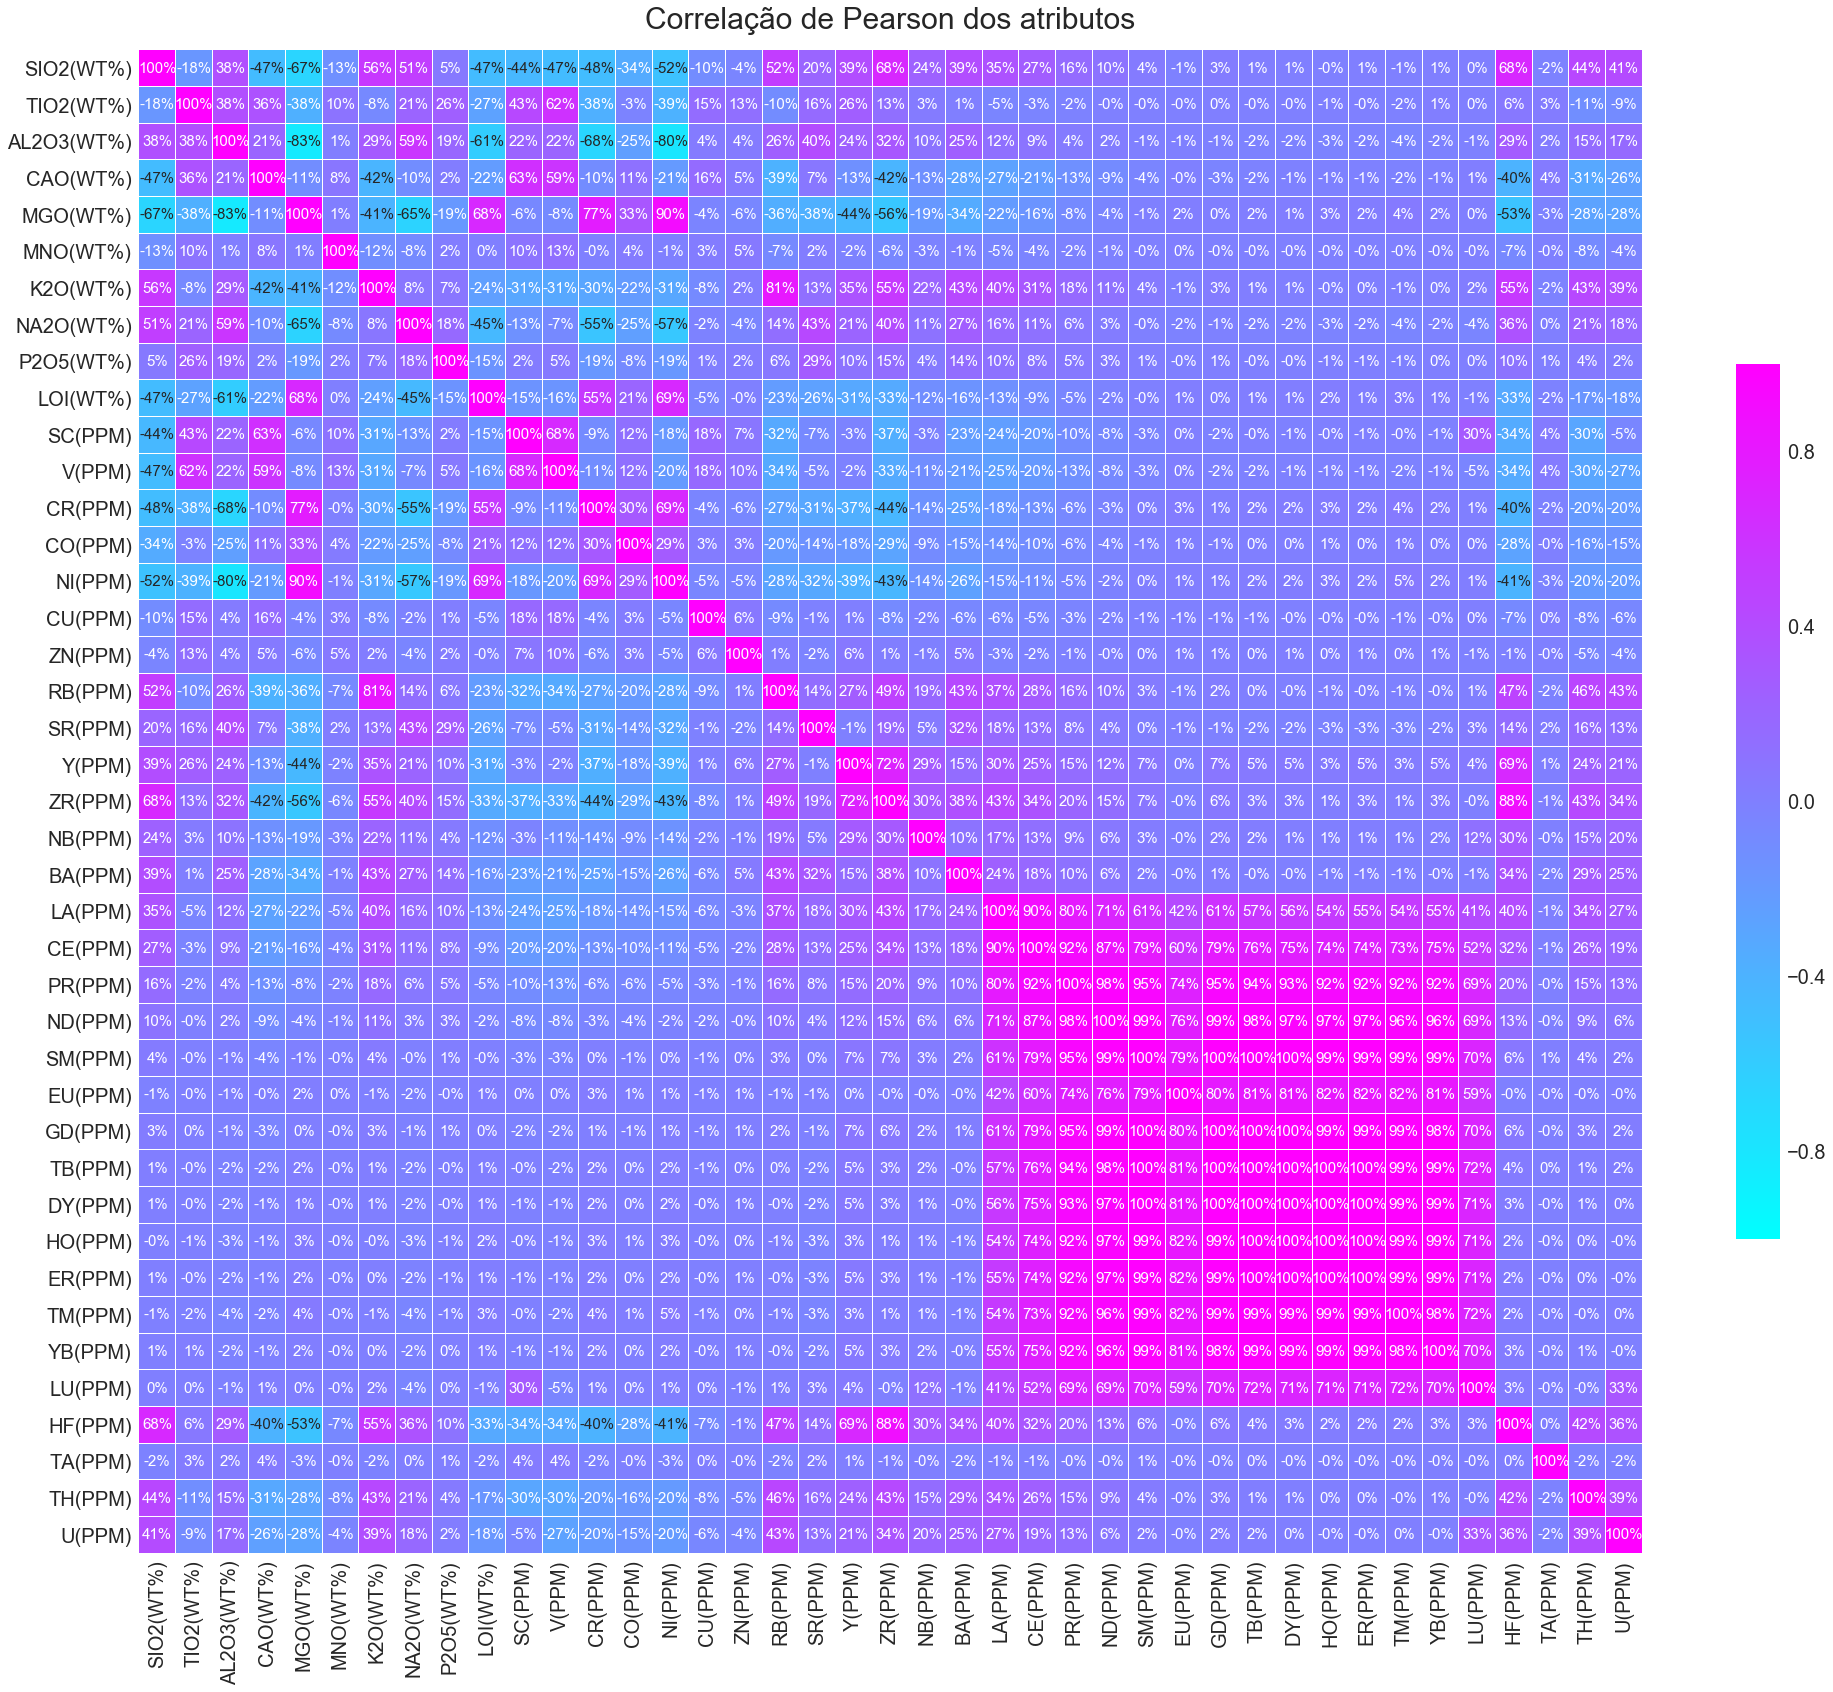

In [1610]:
sns.set(font_scale=2)
plt.figure(figsize=(30,30))
plt.title(u'Correlação de Pearson dos atributos', y=1.01, size=30)

corr_plt = sns.heatmap(df[col_interval].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', 
            annot=True, annot_kws={"size": 15}, fmt='.0%', cbar_kws={"shrink": .5, "fraction": 0.15})
#Correlação apenas das variaveis Intervalo , não se deve fazer em binarios ou nominais
corr_plt.figure.savefig('imgs/Fig_5.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')
plt.show()

### Tranformado distribuição dos dados utilizando BOXCOX

#### Histogramas das variaveis do modelo

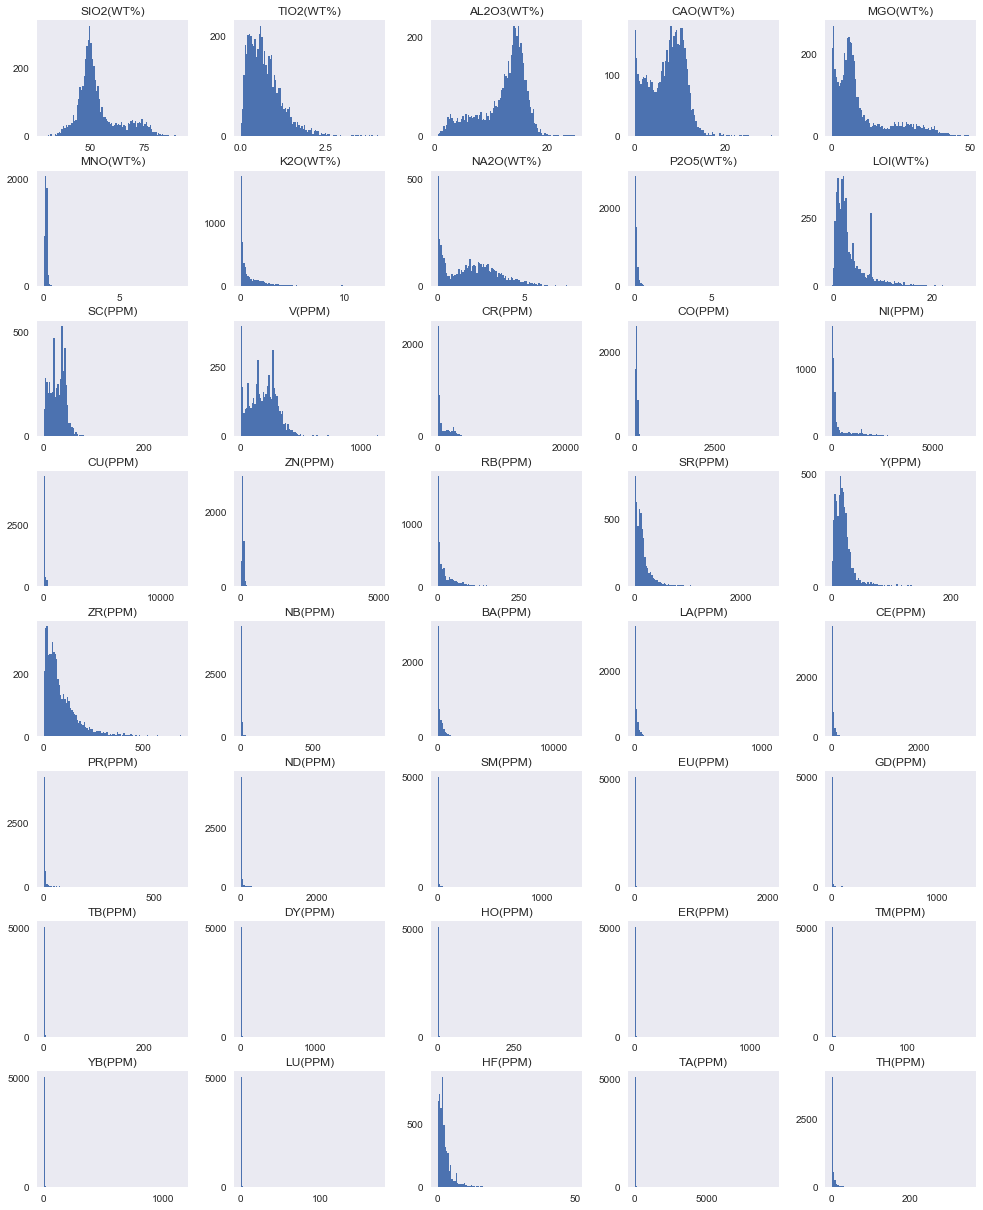

In [1611]:
fig, axes = plt.subplots(len(col_interval)//5, 5, figsize=(15,20))



for col, axis in zip(col_interval, axes.flatten()):
    
    df.hist(column = col, bins = 100, ax=axis, grid=False,
                      xlabelsize=10, ylabelsize=10)
    axis.title.set_size(12)


#fig.show()
fig.savefig('imgs/Fig_6.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')

#### Transformação Boxcox

In [1612]:
from scipy import stats
df_bc = df.copy()

print 'Efetuando transformação Boxcox:'
for col in col_interval:
    
    min_val = df_bc[col].min()
    if min_val < 0:
        df_bc[col] = df_bc[col].apply(lambda x: x - min_val + 0.00001)
    elif min_val == 0:
        df_bc[col] = df_bc[col].apply(lambda x: x + 0.00001)
        
    bc, l = stats.boxcox(df_bc[col])
    df_bc[col] = bc
    print col, 'lambda = ', l

Efetuando transformação Boxcox:
SIO2(WT%) lambda =  -1.1682681538
TIO2(WT%) lambda =  0.338593924463
AL2O3(WT%) lambda =  1.69933096801
CAO(WT%) lambda =  0.765103125068
MGO(WT%) lambda =  0.26233174976
MNO(WT%) lambda =  0.27457102117
K2O(WT%) lambda =  0.201575117976
NA2O(WT%) lambda =  0.424409137733
P2O5(WT%) lambda =  0.303291699702
LOI(WT%) lambda =  0.0766490319287
SC(PPM) lambda =  0.57787468988
V(PPM) lambda =  0.551663202021
CR(PPM) lambda =  0.166745724553
CO(PPM) lambda =  0.42260625409
NI(PPM) lambda =  0.168120124414
CU(PPM) lambda =  0.292557965328
ZN(PPM) lambda =  0.228366631258
RB(PPM) lambda =  0.200459412116
SR(PPM) lambda =  0.253915822652
Y(PPM) lambda =  0.226172578263
ZR(PPM) lambda =  0.245242558688
NB(PPM) lambda =  0.257558055826
BA(PPM) lambda =  0.217435467514
LA(PPM) lambda =  0.142705645354
CE(PPM) lambda =  0.136994618589
PR(PPM) lambda =  0.1900291496
ND(PPM) lambda =  0.15099283026
SM(PPM) lambda =  0.11592668677
EU(PPM) lambda =  0.143733688128
GD(PPM

#### Histograma das variaveis após transformação Boxcox

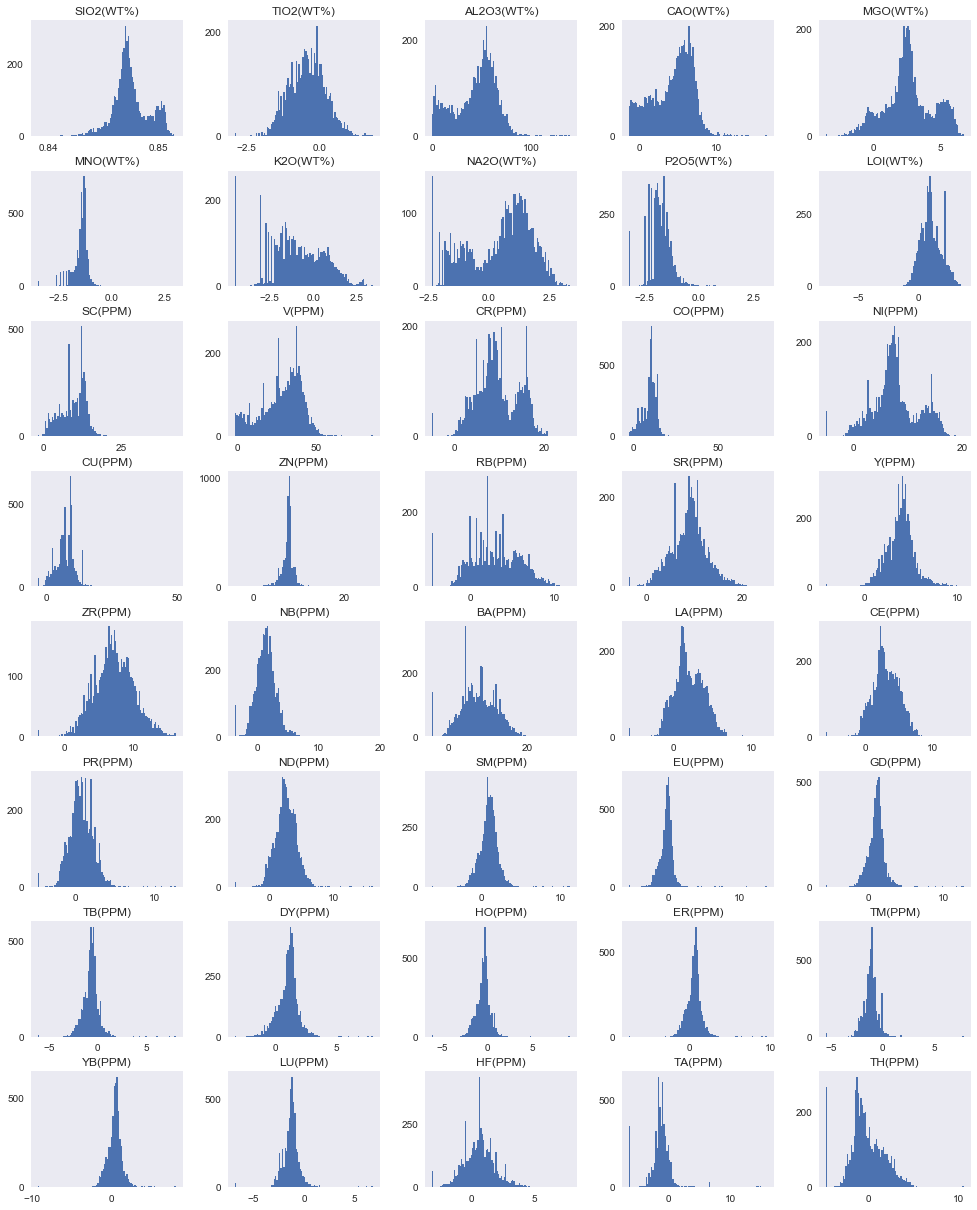

In [1613]:
fig, axes = plt.subplots(len(col_interval)//5, 5, figsize=(15, 20))
for col, axis in zip(col_interval, axes.flatten()):
    df_bc.hist(column = col, bins = 100, ax=axis, grid=False,
                      xlabelsize=10, ylabelsize=10)
    axis.title.set_size(12)
    
fig.savefig('imgs/Fig_7.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')

### Feature Importance - Random Forest

In [1614]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, 
                            max_depth=8, 
                            min_samples_leaf=4, 
                            max_features=0.2, 
                            n_jobs=-1, 
                            random_state=420)

In [1615]:
rf.fit(df_bc[col_interval], df_bc[col_target])

C:\Users\elias.prado\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0, warm_start=False)

In [1616]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [1617]:
feature_importance = get_feature_importance_df(rf.feature_importances_, col_interval, len(col_interval))

In [1618]:
feature_importance

feature  importance
0     MGO(WT%)        0.10
1      CU(PPM)        0.10
2      ZN(PPM)        0.08
3    SIO2(WT%)        0.08
4      CO(PPM)        0.08
5      NI(PPM)        0.05
6      SC(PPM)        0.04
7   AL2O3(WT%)        0.04
8       V(PPM)        0.04
9      HF(PPM)        0.03
10     CR(PPM)        0.03
11     LA(PPM)        0.02
12     TM(PPM)        0.02
13      U(PPM)        0.02
14     SM(PPM)        0.02
15   TIO2(WT%)        0.02
16     PR(PPM)        0.02
17    CAO(WT%)        0.01
18     CE(PPM)        0.01
19     TA(PPM)        0.01
20    MNO(WT%)        0.01
21     HO(PPM)        0.01
22   P2O5(WT%)        0.01
23     EU(PPM)        0.01
24     ND(PPM)        0.01
25      Y(PPM)        0.01
26     BA(PPM)        0.01
27     TH(PPM)        0.01
28     ER(PPM)        0.01
29     ZR(PPM)        0.01
30     DY(PPM)        0.01
31     SR(PPM)        0.01
32     NB(PPM)        0.01
33    LOI(WT%)        0.01
34     YB(PPM)        0.01
35     RB(PPM)        0.01
36     GD(PPM)        0.01
37     LU(PPM)        0.00
38     TB(PPM)        0.00
39    K2O(WT%)        0.00
40   NA2O(WT%)        0.00

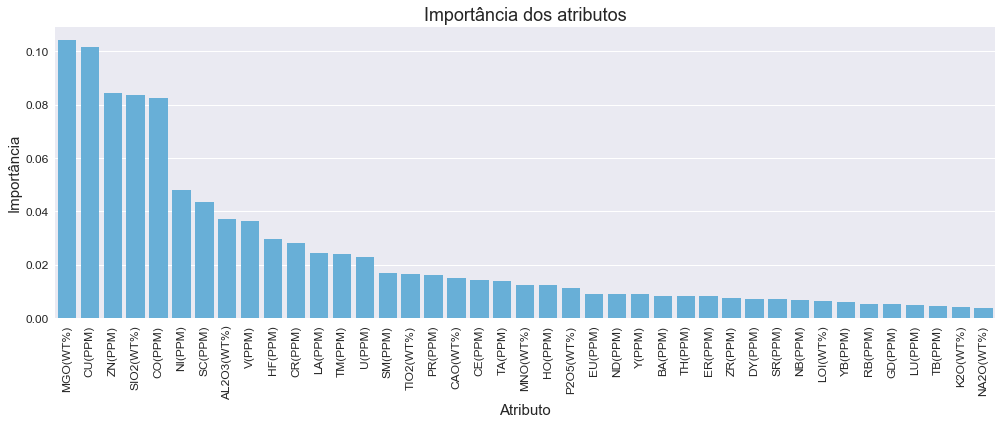

In [1619]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)
sns.barplot(data=feature_importance[:50],x="feature",y="importance",ax=ax,color=default_color)
ax.set_title(u"Importância dos atributos", fontsize=18)
ax.set_xlabel('Atributo',fontsize=15)
ax.set_ylabel(u'Importância',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
for item in ax.get_xticklabels():
    item.set_rotation(90)
    
plt.savefig('imgs/Fig_8.png', bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w')    
plt.show()

### Dividir dados em Teste e Treinamento

In [1620]:
X = df_bc[col_interval]
y = df_bc[col_target]

#### Transformar valores alvos de string para numero

In [1621]:
y_factor = pd.factorize(y['ROCK NAME'])

y.loc[:,'ROCK NAME'] = y_factor[0]
rock_list = y_factor[1]

In [1622]:
from sklearn.model_selection import StratifiedShuffleSplit

test_size = 0.2
seed = 420

split_indexes = StratifiedShuffleSplit(test_size=test_size, random_state=seed)

for train_index, test_index in split_indexes.split(X, y):
    #print X[train_index]
    #print test_index
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

#X_train, X_test, y_train, y_test = StratifiedShuffleSplit(df[col_interval], df[col_target], )

In [1623]:
X.shape

(5113, 41)

In [1624]:
y.shape

(5113, 1)

In [1625]:
X_train.shape

(4090, 41)

In [1626]:
X_test.shape

(1023, 41)

In [1627]:
y_train.shape

(4090, 1)

In [1628]:
y_test.shape

(1023, 1)

### Baseline Models

In [1629]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [1630]:
def cross_val_model(X,y, model, n_splits=3):
    X_ = np.array(X)
    y_ = np.array(y)
    y_ = y_.reshape(y_.shape[0],)
    #print y_.shape

    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017)
    
    j=0
    
    for train_idx, test_idx in folds.split(X_, y_):
        X_train_ = X_[train_idx]
        y_train_ = y_[train_idx]
        X_holdout = X_[test_idx]
        y_holdout = y_[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train_, y_train_)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='accuracy')
        print("    cross_score: %.5f" % cross_score.mean()) 

In [1631]:
def grid_cv(X,y, model, param_grid):
    X_ = np.array(X)
    y_ = np.array(y)
    y_ = y_.reshape(y_.shape[0],)
    
    #t0 = time()
    
    clf = GridSearchCV(model, param_grid, verbose=2,n_jobs=5)
    clf = clf.fit(X_, y_)
    #print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print clf.best_estimator_
    print clf.best_params_
    print clf.best_score_
    return clf.best_estimator_


In [1632]:
def evaluate_classifiers(model, X_validation, y_validation):
    
    X_ = np.array(X_validation)
    y_ = np.array(y_validation)
    y_ = y_.reshape(y_.shape[0],)
    
    results = []
    
    predictions = model.predict(X_)
    acc = accuracy_score(y_, predictions)
    cm = confusion_matrix(y_, predictions)
    report = classification_report(y_, predictions)
    results.append((model, acc, cm, report))
    return results

def report_classifiers_results(model_results,target_list,figname=''):
    for result in model_results:
        name, acc, cm, report = result
        print 'Model: %s' % name
        print 'Accuracy: %f' % acc
        print 'Cofusion Matrix: \n' 
        title = u'Matriz de confusão {}'.format(str(name).split('(')[0])
        print_confusion_matrix(cm,target_list, (15,8),12,figname, title) 
        print 'Report:'
        print report
        print ' '
        

In [1633]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18,figname='',title=''):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, 
                              mask=(df_cm==0), linewidths=2, linecolor=(0.85,0.85,0.85), 
                              cbar_kws={"shrink": 1, "fraction": 0.15})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Classe verdadeira',fontsize=18)
    plt.xlabel('Classe prevista',fontsize=18)
    if title == '':
        plt.title(u'Matriz de confusão', y=1.01, size=22)
    else:
        plt.title(title, y=1.01, size=22)
    
    if figname != '':
        plt.savefig('imgs/{}.png'.format(figname), bbox_inches='tight', dpi=350, frameon=False,facecolor='w', edgecolor='w') 
    plt.show()
    

In [1634]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_train_np = y_.reshape(y_.shape[0],)

#### SVC

In [1635]:
svc_params = {}
svc_params['probability'] = True
svc_params['random_state'] = 420

In [1636]:
svc_model = SVC(**svc_params)

In [1637]:
%%time
cross_val_model(X_train, y_train, svc_model, 3)

Fit SVC fold 1
    cross_score: 0.58269
Fit SVC fold 1
    cross_score: 0.59698
Fit SVC fold 1
    cross_score: 0.60822
Wall time: 29.6 s


In [1638]:
start_time = time.time()

svc_model.fit(X_train_np, y_train_np)

svc_time = time.time() - start_time
print 'Train Time: %fs'%svc_time

Train Time: 13.568000s


Model: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=420, shrinking=True,
  tol=0.001, verbose=False)
Accuracy: 0.691105
Cofusion Matrix: 



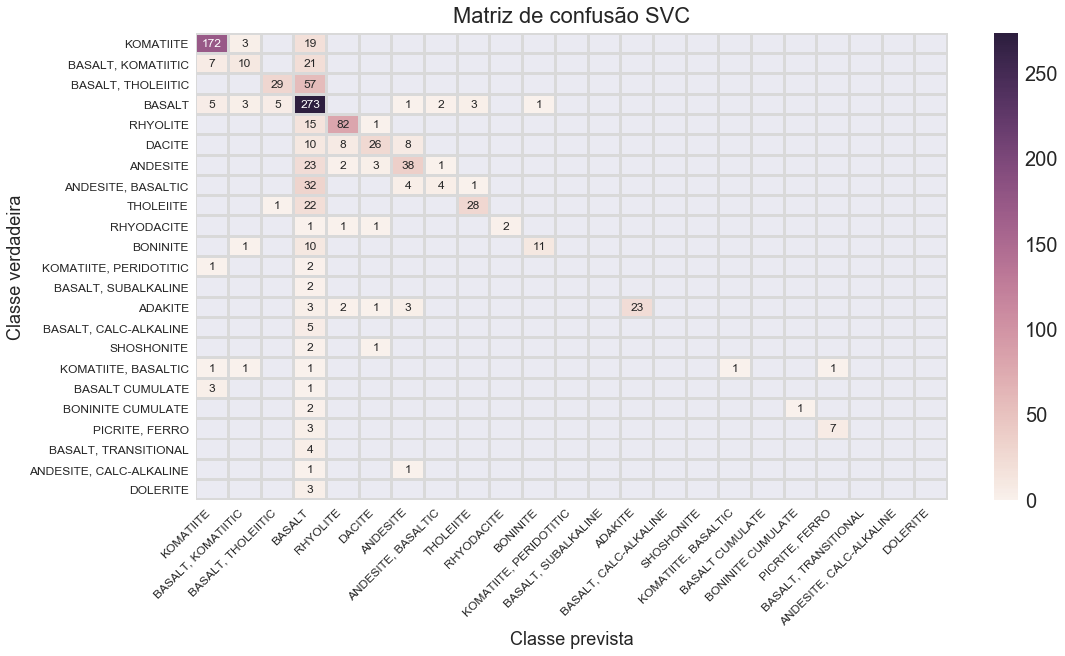

Report:
             precision    recall  f1-score   support

          0       0.91      0.89      0.90       194
          1       0.56      0.26      0.36        38
          2       0.83      0.34      0.48        86
          3       0.53      0.93      0.68       293
          4       0.86      0.84      0.85        98
          5       0.79      0.50      0.61        52
          6       0.69      0.57      0.62        67
          7       0.57      0.10      0.17        41
          8       0.88      0.55      0.67        51
          9       1.00      0.40      0.57         5
         10       0.92      0.50      0.65        22
         11       0.00      0.00      0.00         3
         12       0.00      0.00      0.00         2
         13       1.00      0.72      0.84        32
         14       0.00      0.00      0.00         5
         15       0.00      0.00      0.00         3
         16       1.00      0.20      0.33         5
         17       0.00      0.00     

In [1639]:
svc_result = evaluate_classifiers(svc_model, X_test, y_test)
report_classifiers_results(svc_result,rock_list,'Fig_9')

#### KNN

In [1640]:
knn_params = {}
knn_params['n_neighbors'] = range(3,20,2)
knn_params['weights'] = ['uniform','distance']
knn_params['p'] = [1,2]

In [1641]:
knn_model = KNeighborsClassifier()

In [1642]:
knn_model_gscv = grid_cv(X_train,y_train,knn_model,knn_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   10.2s


Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='distance')
{'n_neighbors': 3, 'weights': 'distance', 'p': 1}
0.785819070905


[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   15.2s finished


In [1643]:
%%time
cross_val_model(X_train, y_train, knn_model_gscv, 3)

Fit KNeighborsClassifier fold 1
    cross_score: 0.70205
Fit KNeighborsClassifier fold 1
    cross_score: 0.70303
Fit KNeighborsClassifier fold 1
    cross_score: 0.71934
Wall time: 177 ms


In [1644]:
start_time = time.time()

knn_model_gscv.fit(X_train_np, y_train_np)

knn_time = time.time() - start_time
print 'Train Time: %fs'%knn_time

Train Time: 0.007000s


Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='distance')
Accuracy: 0.810362
Cofusion Matrix: 



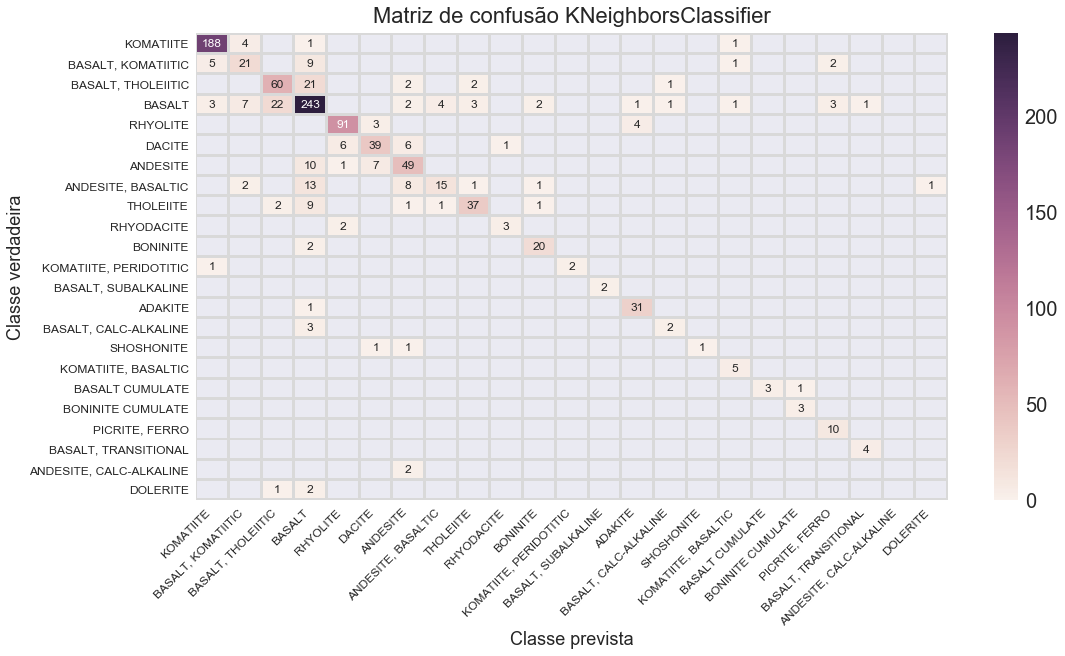

Report:
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       194
          1       0.62      0.55      0.58        38
          2       0.71      0.70      0.70        86
          3       0.77      0.83      0.80       293
          4       0.91      0.93      0.92        98
          5       0.78      0.75      0.76        52
          6       0.69      0.73      0.71        67
          7       0.75      0.37      0.49        41
          8       0.86      0.73      0.79        51
          9       0.75      0.60      0.67         5
         10       0.83      0.91      0.87        22
         11       1.00      0.67      0.80         3
         12       1.00      1.00      1.00         2
         13       0.86      0.97      0.91        32
         14       0.50      0.40      0.44         5
         15       1.00      0.33      0.50         3
         16       0.62      1.00      0.77         5
         17       1.00      0.75     

In [1645]:
knn_result = evaluate_classifiers(knn_model_gscv, X_test, y_test)
report_classifiers_results(knn_result,rock_list,'Fig_10')

#### Random Forest

In [1646]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = range(100,500,50)
rf_params['max_depth'] = range(3,15,2)
rf_params['min_samples_split'] = range(10,50,5)
rf_params['min_samples_leaf'] = range(3,15,2)
rf_params['criterion'] = ['gini','entropy']
rf_params['random_state'] = [420]

In [1647]:
rf_model = RandomForestClassifier()

In [1648]:
rf_model_gscv = grid_cv(X_train,y_train,rf_model,rf_params)

Fitting 3 folds for each of 4608 candidates, totalling 13824 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   48.1s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  7.7min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed: 11.1min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed: 20.7min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 27.1min
[Parallel(n_jobs=5)]: Done 4891 tasks      | elapsed: 34.7min
[Parallel(n_jobs=5)]: Done 5822 tasks      | elapsed: 42.9min
[Parallel(n_jobs=5)]: Done 6835 tasks      | elapsed: 51.8min
[Parallel(n_jobs=5)]: Done 7928 tasks      | elapsed: 65.9min
[Parallel(n_jobs=5)]: Done 9103 tasks      | elapsed: 86.7min
[Parallel(n_jobs=5)]: Done 10358 tasks      | elapsed: 113.1min
[Parallel(

Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=420, verbose=0, warm_start=False)
{'min_samples_leaf': 3, 'n_estimators': 400, 'random_state': 420, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 13}
0.845476772616


In [1649]:
%%time
cross_val_model(X_train, y_train, rf_model_gscv, 3)

Fit RandomForestClassifier fold 1
    cross_score: 0.77916
Fit RandomForestClassifier fold 1
    cross_score: 0.79102
Fit RandomForestClassifier fold 1
    cross_score: 0.80273
Wall time: 27.5 s


In [1650]:
start_time = time.time()

rf_model_gscv.fit(X_train_np, y_train_np)

rf_time = time.time() - start_time
print 'Train Time: %fs'%rf_time

Train Time: 5.491000s


Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=420, verbose=0, warm_start=False)
Accuracy: 0.854350
Cofusion Matrix: 



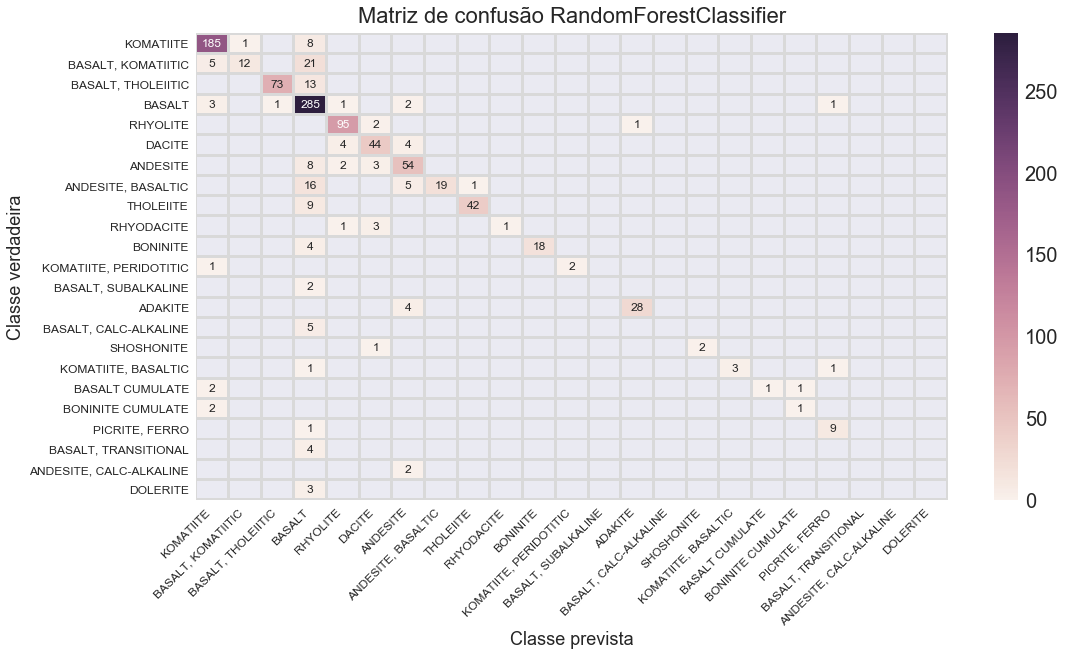

Report:
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       194
          1       0.92      0.32      0.47        38
          2       0.99      0.85      0.91        86
          3       0.75      0.97      0.85       293
          4       0.92      0.97      0.95        98
          5       0.83      0.85      0.84        52
          6       0.76      0.81      0.78        67
          7       1.00      0.46      0.63        41
          8       0.98      0.82      0.89        51
          9       1.00      0.20      0.33         5
         10       1.00      0.82      0.90        22
         11       1.00      0.67      0.80         3
         12       0.00      0.00      0.00         2
         13       0.97      0.88      0.92        32
         14       0.00      0.00      0.00         5
         15       1.00      0.67      0.80         3
         16       1.00      0.60      0.75         5
         17       1.00      0.25     

In [1651]:
rf_result = evaluate_classifiers(rf_model_gscv, X_test, y_test)
report_classifiers_results(rf_result,rock_list,'Fig_11')

#### XGBoost

##### Escolhendo numero de estimadores

In [1652]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = range(20,500,10)
xgb_params['max_depth'] = [5]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.8]  
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]

In [1653]:
xgb_model = XGBClassifier()

In [1654]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 144 out of 144 | elapsed: 21.1min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=390,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 390, 'subsample': 0.8, 'max_depth': 5, 'gamma': 0}
0.921760391198


n_estimators = 390 encontrado.

Como fiz o step de 10 para o range (range(20,500,10)), agora vou refinar o n_estimators com step de 1 (range(380,400,1))

In [1655]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = range(380,400,1)
xgb_params['max_depth'] = [5]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.8]  
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]

In [1656]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  7.7min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed: 13.2min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=382,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 382, 'subsample': 0.8, 'max_depth': 5, 'gamma': 0}
0.921760391198


**n_estimators = 383** encontrado

##### Escolhendo max_depth e min_child_weight

In [1657]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = range(1,10,2)
xgb_params['n_estimators'] = [383]
xgb_params['max_depth'] = range(3,20,2)
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.8]  
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]

In [1658]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  7.1min
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed: 27.0min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=383,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 383, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0}
0.924694376528


** max_depth = 3, min_child_weight = 1 ** escolhidos

##### Escolhendo gamma

In [1659]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = [383]
xgb_params['max_depth'] = [3]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.8]  
xgb_params['gamma'] = [i/10.0 for i in range(0,10)]
xgb_params['scale_pos_weight'] = [1]

In [1660]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  7.4min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=383, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
{'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 383, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0.0}
0.924694376528


**gamma = 0** escolhido

##### Recalibrar numero de estimadores

In [1661]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = range(100,500,20)
xgb_params['max_depth'] = [3]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.8]  
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]

In [1662]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed: 10.1min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=480,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 480, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0}
0.926405867971


** Encontrado n_estimators = 480 **

Refinar Busca com step de 2

In [1663]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = range(460,500,2)
xgb_params['max_depth'] = [3]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.8]  
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]

In [1664]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  8.4min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed: 14.8min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=480,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 480, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0}
0.926405867971


** n_estimators = 480 ** escolhido


##### Escolhendo subsample e colsample_bytree

In [1665]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = [480]
xgb_params['max_depth'] = [3]
xgb_params['subsample'] = [i/10.0 for i in range(6,10)]
xgb_params['colsample_bytree'] = [i/10.0 for i in range(6,10)] 
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]

In [1666]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed: 11.8min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=480,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'colsample_bytree': 0.9, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 480, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0}
0.927872860636


** colsample_bytree = 0.9, subsample = 0.8 ** escolhidos

##### Escolhendo parametro de regularização reg_alpha

In [1667]:
xgb_params = {}
xgb_params['learning_rate'] = [0.1]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = [480]
xgb_params['max_depth'] = [3]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.9] 
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]
xgb_params['reg_alpha'] = [0, 1e-5, 1e-2, 0.1, 1, 100]

In [1668]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  5.0min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=480,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'reg_alpha': 0, 'colsample_bytree': 0.9, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 480, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0}
0.927872860636


** reg_alpha = 0 ** encontrado

#### Reduzindo learning_rate de 0.1 para 0.01 e recalculando n_estimators

In [1669]:
xgb_params = {}
xgb_params['learning_rate'] = [0.01]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = range(480,2030,50)
xgb_params['max_depth'] = [3]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.9]
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]
xgb_params['reg_alpha'] = [0]

In [1670]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 31 candidates, totalling 93 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 15.2min
[Parallel(n_jobs=5)]: Done  93 out of  93 | elapsed: 71.0min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1830,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'reg_alpha': 0, 'colsample_bytree': 0.9, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 1830, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0}
0.91858190709


** n_estimators = 1830 **

Refinando step de 50 para 10

In [1671]:
xgb_params = {}
xgb_params['learning_rate'] = [0.01]
xgb_params['min_child_weight'] = [1]
xgb_params['n_estimators'] = range(1780,1880,10)
xgb_params['max_depth'] = [3]
xgb_params['subsample'] = [0.8]
xgb_params['colsample_bytree'] = [0.9]
xgb_params['gamma'] = [0]
xgb_params['scale_pos_weight'] = [1]
xgb_params['reg_alpha'] = [0]

In [1672]:
xgb_model_gscv = grid_cv(X_train,y_train,xgb_model,xgb_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 33.2min finished


Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1840,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'reg_alpha': 0, 'colsample_bytree': 0.9, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 1840, 'subsample': 0.8, 'max_depth': 3, 'gamma': 0}
0.918826405868


** n_estimators = 1840 ** encontrado

In [1673]:
%%time
cross_val_model(X_train, y_train, xgb_model_gscv, 3)

Fit XGBClassifier fold 1
    cross_score: 0.85876
Fit XGBClassifier fold 1
    cross_score: 0.84725
Fit XGBClassifier fold 1
    cross_score: 0.86259
Wall time: 28min 19s


In [1674]:
start_time = time.time()

xgb_model_gscv.fit(X_train_np, y_train_np)

xgb_time = time.time() - start_time
print 'Train Time: %fs'%xgb_time

Train Time: 437.901000s


Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1840,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
Accuracy: 0.934506
Cofusion Matrix: 



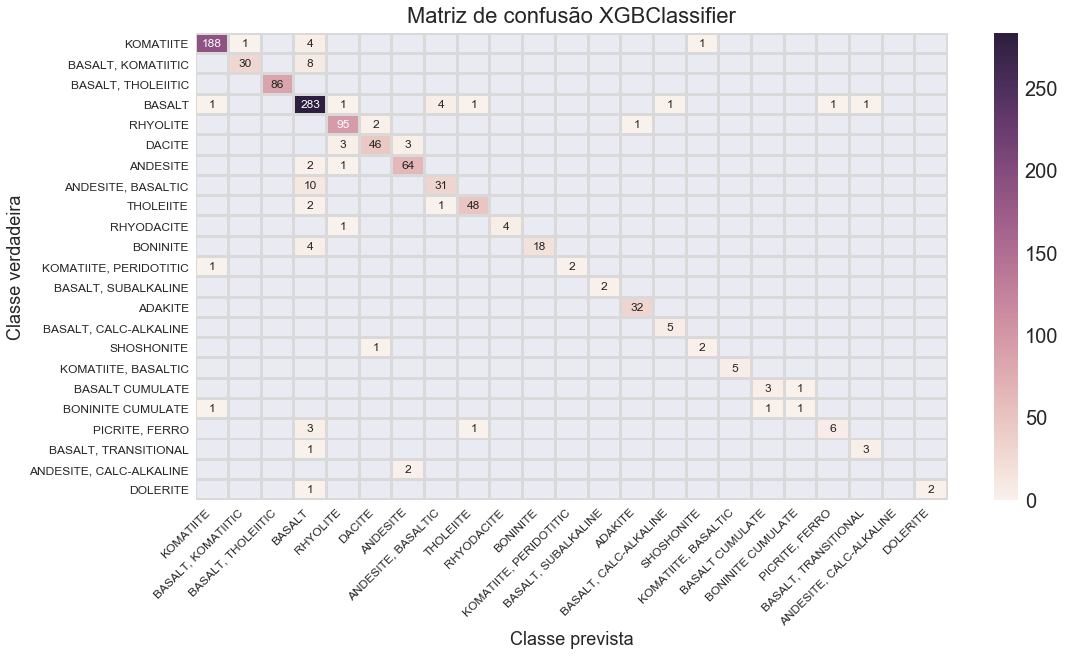

Report:
             precision    recall  f1-score   support

          0       0.98      0.97      0.98       194
          1       0.97      0.79      0.87        38
          2       1.00      1.00      1.00        86
          3       0.89      0.97      0.93       293
          4       0.94      0.97      0.95        98
          5       0.94      0.88      0.91        52
          6       0.93      0.96      0.94        67
          7       0.86      0.76      0.81        41
          8       0.96      0.94      0.95        51
          9       1.00      0.80      0.89         5
         10       1.00      0.82      0.90        22
         11       1.00      0.67      0.80         3
         12       1.00      1.00      1.00         2
         13       0.97      1.00      0.98        32
         14       0.83      1.00      0.91         5
         15       0.67      0.67      0.67         3
         16       1.00      1.00      1.00         5
         17       0.75      0.75     

In [1675]:
xgb_result = evaluate_classifiers(xgb_model_gscv, X_test, y_test)
report_classifiers_results(xgb_result,rock_list,'Fig_12')

### Base model Results

In [1676]:
model_accuracys = {}
model_accuracys['SVC'] = svc_result[0][1]
model_accuracys['KNN'] = knn_result[0][1]
model_accuracys['RF'] = rf_result[0][1]
model_accuracys['XGB'] = xgb_result[0][1]
model_accuracys_df = pd.DataFrame(model_accuracys, index=['Acurracy'])

model_cv_time = {}
model_cv_time['SVC'] = svc_time
model_cv_time['KNN'] = knn_time
model_cv_time['RF'] = rf_time
model_cv_time['XGB'] = xgb_time
model_cv_time_df = pd.DataFrame(model_cv_time, index=['Train Time (s)'])

model_results_df = model_accuracys_df.append(model_cv_time_df)
model_results_df.sort_values('Acurracy',axis=1)

SVC  KNN   RF    XGB
Acurracy        0.69 0.81 0.85   0.93
Train Time (s) 13.57 0.01 5.49 437.90

### Stacking

In [1677]:
log_model = LogisticRegression()

#### Ultilizar os 3 melhores modelos

In [1678]:
xgb_model_ = xgb_result[0][0]
rf_model_ = rf_result[0][0]
knn_model_ = knn_result[0][0]

In [1679]:
from mlxtend.classifier import StackingCVClassifier

stack_model_cvc = StackingCVClassifier(classifiers=[xgb_model_,rf_model_,knn_model_], 
                                   use_probas=True,
                                   meta_classifier=log_model,
                                   cv = 3,
                                   stratify=True,
                                   shuffle=True
                                  )

In [1680]:
%%time
cross_val_model(X_train, y_train, stack_model_cvc, 2)

Fit StackingCVClassifier fold 1
    cross_score: 0.87915
Fit StackingCVClassifier fold 1
    cross_score: 0.87615
Wall time: 1h 5min 14s


In [1681]:
start_time = time.time()

stack_model_cvc.fit(X_train_np, y_train_np)

stack_time = time.time() - start_time
print 'Train Time: %fs'%stack_time


Train Time: 1323.606000s


Model: StackingCVClassifier(classifiers=[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1840,
       n_jobs=1, nthread=None, objective='multi:softprob', random_sta...owski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='distance')],
           cv=3,
           meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           shuffle=True, stratify=True, use_features_in_secondary=False,
           use_probas=True, verbose=0)
Accuracy: 0.945259
Cofusion Matrix: 



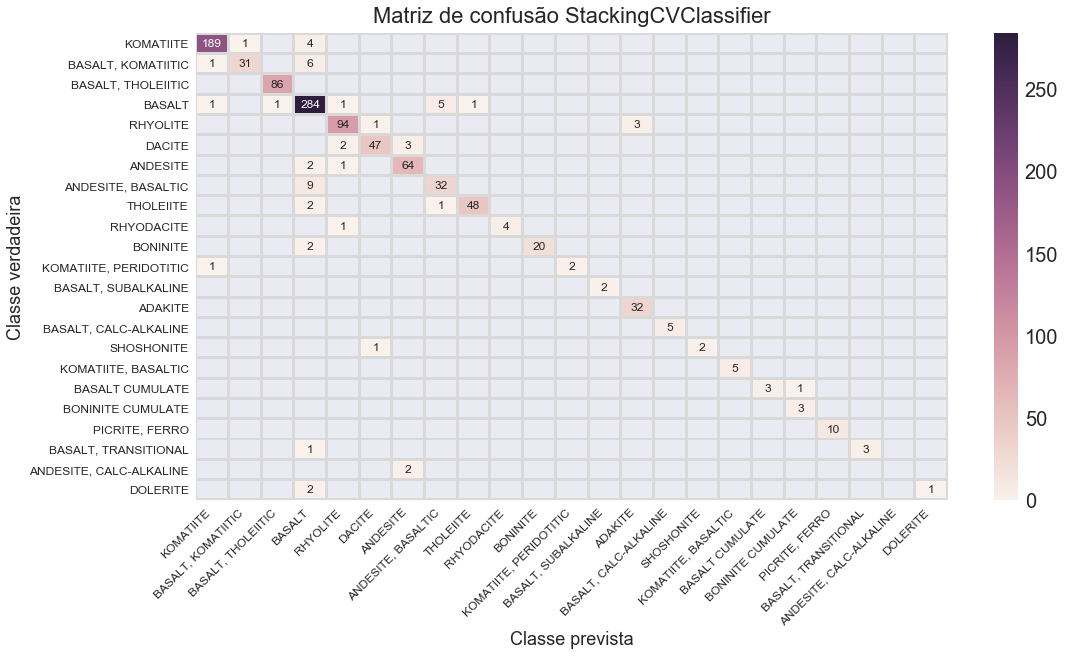

Report:
             precision    recall  f1-score   support

          0       0.98      0.97      0.98       194
          1       0.97      0.82      0.89        38
          2       0.99      1.00      0.99        86
          3       0.91      0.97      0.94       293
          4       0.95      0.96      0.95        98
          5       0.96      0.90      0.93        52
          6       0.93      0.96      0.94        67
          7       0.84      0.78      0.81        41
          8       0.98      0.94      0.96        51
          9       1.00      0.80      0.89         5
         10       1.00      0.91      0.95        22
         11       1.00      0.67      0.80         3
         12       1.00      1.00      1.00         2
         13       0.91      1.00      0.96        32
         14       1.00      1.00      1.00         5
         15       1.00      0.67      0.80         3
         16       1.00      1.00      1.00         5
         17       1.00      0.75     

In [1682]:
stack_result = evaluate_classifiers(stack_model_cvc, X_test, y_test)
report_classifiers_results(stack_result,rock_list,'Fig_13')

In [1683]:
model_accuracys = {}
model_accuracys['SVC'] = svc_result[0][1]
model_accuracys['KNN'] = knn_result[0][1]
model_accuracys['RF'] = rf_result[0][1]
model_accuracys['XGB'] = xgb_result[0][1]
model_accuracys['STACK'] = stack_result[0][1]
model_accuracys_df = pd.DataFrame(model_accuracys, index=['Acurracy'])

model_cv_time = {}
model_cv_time['SVC'] = svc_time
model_cv_time['KNN'] = knn_time
model_cv_time['RF'] = rf_time
model_cv_time['XGB'] = xgb_time
model_cv_time['STACK'] = stack_time
model_cv_time_df = pd.DataFrame(model_cv_time, index=['Train Time (s)'])

model_results_df = model_accuracys_df.append(model_cv_time_df)
model_results_df.sort_values('Acurracy',axis=1)

SVC  KNN   RF    XGB   STACK
Acurracy        0.69 0.81 0.85   0.93    0.95
Train Time (s) 13.57 0.01 5.49 437.90 1323.61